In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
import matplotlib
matplotlib.rc('pdf', fonttype=42)

In [270]:
import matplotlib.pyplot as plt
import pandas as pd
import tools as t
import numpy as np

In [4]:
!scp frank:/import/dima-scratch/phd-buildout/experiments/emnlp14/results_all.csv .

results_all.csv                               100%   25MB   8.4MB/s   00:03    


In [5]:
!wc -l results_all.csv

255091 results_all.csv


In [6]:
results = t.read_results()

# Max selection

In [7]:
max_selection_simlex = t.plot_selection(
    results[results.index.get_level_values('operator') == 'head'],
    dataset='SimLex999',
    selector_function=t.max_('men'),
    plot=False,
)

In [8]:
max_selection_men = t.plot_selection(
    results[results.index.get_level_values('operator') == 'head'],
    dataset='men',
    selector_function=t.max_('SimLex999'),
    plot=False,
)

# Cross-validation

In [9]:
cross_validation_selection_simlex = t.plot_selection(
    results[results.index.get_level_values('operator') == 'head'],
    dataset='SimLex999',
    selector_function=t.cross_validation('men'),
    plot=False,
)

In [10]:
cross_validation_selection_men = t.plot_selection(
    results[results.index.get_level_values('operator') == 'head'],
    dataset='men',
    selector_function=t.cross_validation('SimLex999'),
    plot=False,
)

# Heuristics

## SimLex-999

In [11]:
parameters = [
    'dimensionality', 'discr', 'cds', 'freq', 'neg', 'similarity',
]

In [12]:
t.anova(
    response='SimLex999',
    predictors=parameters,
    data=results,
).rsquared_adj

0.86701695238077925

In [13]:
feature_ablation_simlex = t.calculate_feature_ablation(
    responses=(
        'SimLex999',
        # 'men',
    ),
    predictors=parameters,
    data=results,
)

# feature_ablation.plot(kind='barh')#.get_figure().savefig('figures/emnlp2013_turk-parameter-ablation.pdf')
feature_ablation_simlex.sort_values(('partial R2', 'SimLex999'), ascending=False, inplace=True)

feature_ablation_simlex.round(3)

,partial R2
response,SimLex999
predictor,
similarity,0.379
freq,0.268
neg,0.241
dimensionality,0.083
discr,0.077
cds,0.064


In [14]:
_ = feature_ablation_simlex.copy()
_.columns.names = ['', '']
(
    _['partial R2']
    .round(3)
    .to_latex('figures/SimLex999-ablation.tex')
)

In [15]:
heuristics_selection_collection_simlex = {}

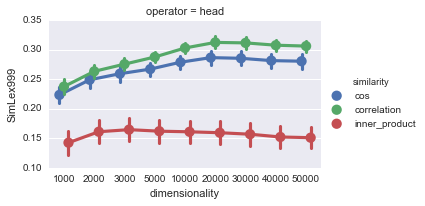

In [16]:
f = t.plot_interaction(results['max'], feature_ablation_simlex.index[0], 'SimLex999')

In [17]:
assert feature_ablation_simlex.index[0] == 'similarity'
r = results['max'].reset_index()

heuristics_selection_collection_simlex[0] = r.loc[
    r['similarity'] == 'correlation'
]

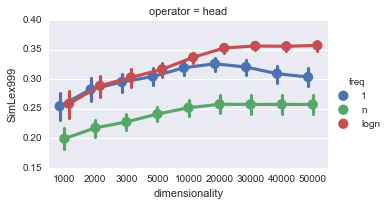

In [18]:
t.plot_interaction(heuristics_selection_collection_simlex[0], feature_ablation_simlex.index[1], 'SimLex999')

In [19]:
assert feature_ablation_simlex.index[1] == 'freq'

r = heuristics_selection_collection_simlex[0]

heuristics_selection_collection_simlex[1] =  r.loc[
    r['freq'] == 'logn'
]

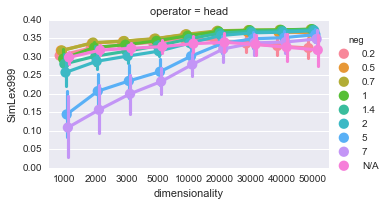

In [20]:
t.plot_interaction(heuristics_selection_collection_simlex[1], feature_ablation_simlex.index[2], 'SimLex999')

In [21]:
assert feature_ablation_simlex.index[2] == 'neg'

r = heuristics_selection_collection_simlex[1]

heuristics_selection_collection_simlex[2] =  r.loc[
    (r['neg'] == 0.7)
]

In [22]:
# Skip dimensionality
assert feature_ablation_simlex.index[3] == 'dimensionality'

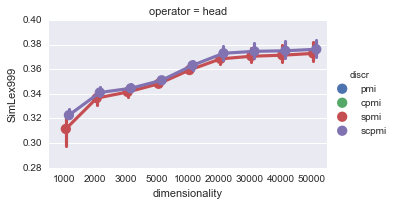

In [23]:
t.plot_interaction(heuristics_selection_collection_simlex[2], feature_ablation_simlex.index[4], 'SimLex999')

In [24]:
assert feature_ablation_simlex.index[4] == 'discr'

r = heuristics_selection_collection_simlex[2]

heuristics_selection_collection_simlex[3] =  r.loc[
    (r['discr'] == 'scpmi')
]

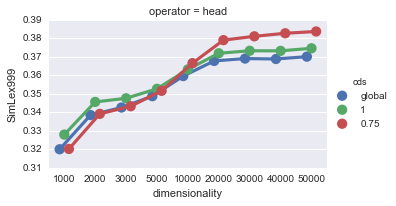

In [25]:
t.plot_interaction(heuristics_selection_collection_simlex[3], feature_ablation_simlex.index[5], 'SimLex999')

In [26]:
assert feature_ablation_simlex.index[5] == 'cds'

r = heuristics_selection_collection_simlex[3]

heuristics_selection_collection_simlex[4] =  r.loc[
    # *skip tuning for 50K
    (~(r['dimensionality'] < 10000) | ((r['cds'] == '1'))) &
    (~(r['dimensionality'] >= 10000) | ((r['cds'] == '0.75'))) &
    True
]

In [27]:
assert len(feature_ablation_simlex) == 6

In [28]:
heuristics_selection_simlex = heuristics_selection_collection_simlex[4].set_index(['operator', 'dimensionality'], drop=False)
heuristics_selection_simlex['selection'] = 'heuristics'

## MEN

In [29]:
t.anova(
    response='men',
    predictors=parameters,
    data=results,
).rsquared_adj

0.73306515868630373

In [30]:
feature_ablation_men = t.calculate_feature_ablation(
    responses=(
        'men',
    ),
    predictors=parameters,
    data=results,
)

# feature_ablation.plot(kind='barh')#.get_figure().savefig('figures/emnlp2013_turk-parameter-ablation.pdf')
feature_ablation_men.sort_values(('partial R2', 'men'), ascending=False, inplace=True)

feature_ablation_men.round(3)

,partial R2
response,men
predictor,
neg,0.309
freq,0.204
similarity,0.183
discr,0.119
dimensionality,0.108
cds,0.086


In [31]:
_ = feature_ablation_men.copy()
_.columns.names = ['', '']
(
    _['partial R2']
    .round(3)
    .to_latex('figures/men-ablation.tex')
)

In [32]:
heuristics_selection_collection_men = {}

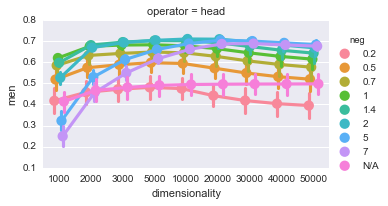

In [33]:
t.plot_interaction(results['max'], feature_ablation_men.index[0], 'men')

In [34]:
assert feature_ablation_men.index[0] == 'neg'

r = results['max'].reset_index()

heuristics_selection_collection_men[0] =  r.loc[
    # *coarse selection
    (~(r['dimensionality'] < 20000) | ((r['neg'] == 2) | (r['neg'] == 'N/A'))) &
    (~(r['dimensionality'] >= 20000) | ((r['neg'] == 5) | (r['neg'] == 'N/A'))) &
    True
]

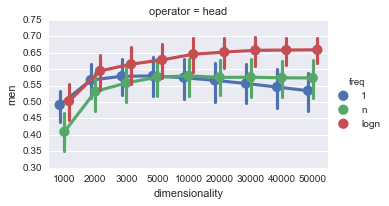

In [35]:
t.plot_interaction(heuristics_selection_collection_men[0], feature_ablation_men.index[1], 'men')

In [36]:
assert feature_ablation_men.index[1] == 'freq'

r = heuristics_selection_collection_men[0]

heuristics_selection_collection_men[1] =  r.loc[
    (r['freq'] == 'logn')
]

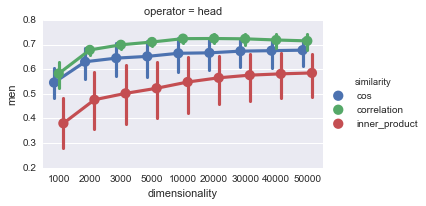

In [37]:
t.plot_interaction(heuristics_selection_collection_men[1], feature_ablation_men.index[2], 'men')

In [38]:
assert feature_ablation_men.index[2] == 'similarity'

r = heuristics_selection_collection_men[1]

heuristics_selection_collection_men[2] =  r.loc[
    (r['similarity'] == 'correlation')
]

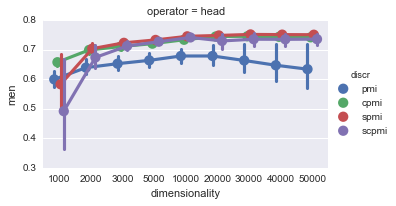

In [39]:
t.plot_interaction(heuristics_selection_collection_men[2], feature_ablation_men.index[3], 'men')

In [40]:
assert feature_ablation_men.index[3] == 'discr'

r = heuristics_selection_collection_men[2]

heuristics_selection_collection_men[3] =  r.loc[
    (r['discr'] == 'spmi')
]

In [41]:
# Skip dimensionality
assert feature_ablation_men.index[4] == 'dimensionality'

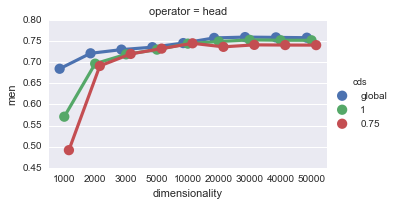

In [42]:
t.plot_interaction(heuristics_selection_collection_men[3], feature_ablation_men.index[5], 'men')

In [43]:
assert feature_ablation_men.index[5] == 'cds'

r = heuristics_selection_collection_men[3]

heuristics_selection_collection_men[4] =  r.loc[
    (r['cds'] == 'global')
]

In [44]:
assert len(feature_ablation_men) == 6

In [45]:
heuristics_selection_men = heuristics_selection_collection_men[4].set_index(['operator', 'dimensionality'], drop=False)
heuristics_selection_men['selection'] = 'heuristics'

#  Parameter selection comparison

In [46]:
'{:.3f}'.format(
    t.average_error(
        max_selection_simlex,
        heuristics_selection_simlex,
        'SimLex999',
    ),
)

'0.039'

In [47]:
'{:.3f}'.format(
    t.average_error(
        max_selection_men,
        heuristics_selection_men,
        'men',
    ),
)

'0.008'

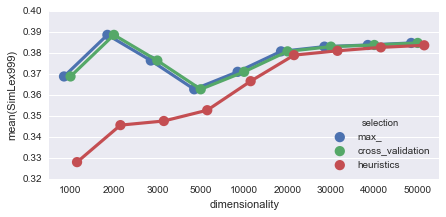

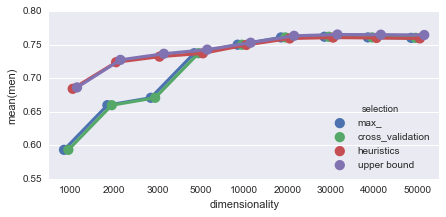

In [48]:
f, ax = plt.subplots(figsize=(7, 3))
t.plot_parameter_selection_comparison(
    [
        max_selection_simlex,
        cross_validation_selection_simlex,
        heuristics_selection_simlex,
    ],
    'SimLex999',
    ax=ax,
)
f.savefig('figures/SimLex999-results.pdf')

f, ax = plt.subplots(figsize=(7, 3))
t.plot_parameter_selection_comparison(
    [
        max_selection_simlex,
        cross_validation_selection_simlex,
        heuristics_selection_simlex,

        max_selection_men.assign(selection='upper bound')
    ],
    'SimLex999',
    'men',
    ax=ax,
)
f.savefig('figures/SimLex999-transfer.pdf')

In [49]:
max_selection_simlex.sort_index().round({'SimLex999': 3}).loc['head'].to_latex(
    'figures/SimLex999-max_-selection.tex',
    columns=[
        'SimLex999',
        'freq',
        'discr',
        'cds',
        'neg',
        'similarity',
    ],
)

In [50]:
heuristics_selection_simlex.sort_index().round({'SimLex999': 3}).loc['head'].to_latex(
    'figures/SimLex999-heuristics-selection.tex',
    columns=[
        'SimLex999',
        'freq',
        'discr',
        'cds',
        'neg',
        'similarity',
    ],
)

#### MEN

In [51]:
max_selection_men.sort_index().round({'men': 3}).loc['head'].to_latex(
    'figures/men-max_-selection.tex',
    columns=[
        'men',
        'freq',
        'discr',
        'cds',
        'neg',
        'similarity',
    ],
)

In [52]:
heuristics_selection_men.sort_index().round({'men': 3}).loc['head'].to_latex(
    'figures/men-heuristics-selection.tex',
    columns=[
        'men',
        'freq',
        'discr',
        'cds',
        'neg',
        'similarity',
    ],
)

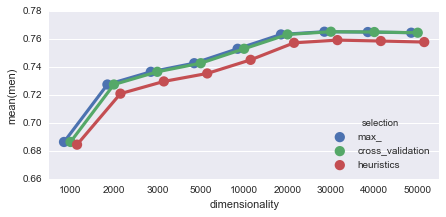

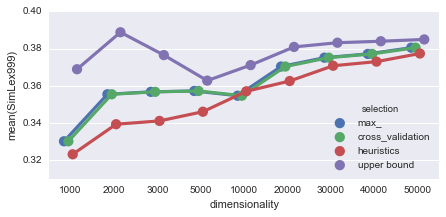

In [53]:
f, ax = plt.subplots(figsize=(7, 3))
t.plot_parameter_selection_comparison(
    [
        max_selection_men,
        cross_validation_selection_men,
        heuristics_selection_men,
    ],
    'men',
    ax=ax,
)
f.savefig('figures/men-results.pdf')

f, ax = plt.subplots(figsize=(7, 3))
t.plot_parameter_selection_comparison(
    [
        max_selection_men,
        cross_validation_selection_men,
        heuristics_selection_men,

        max_selection_simlex.assign(selection='upper bound')
    ],
    'men',
    'SimLex999',
    ax=ax,
)
f.savefig('figures/men-transfer.pdf')

In [54]:
'SimLex-999 to MEN (heuristics): {:.3f}'.format(
    t.average_error(
        max_selection_men,
        heuristics_selection_simlex,
        'men',
    ),
)

'SimLex-999 to MEN (heuristics): 0.006'

In [55]:
'SimLex-999 to MEN (max): {:.3f}'.format(
    t.average_error(
        max_selection_men,
        max_selection_simlex,
        'men',
    ),
)

'SimLex-999 to MEN (max): 0.039'

In [56]:
'MEN to SimLex999 (heuristics): {:.3f}'.format(
    t.average_error(
        max_selection_simlex,
        heuristics_selection_men,
        'SimLex999',
    ),
)

'MEN to SimLex999 (heuristics): 0.062'

In [57]:
'MEN to SimLex999 (heuristics): {:.3f}'.format(
    t.average_error(
        max_selection_simlex,
        max_selection_men,
        'SimLex999',
    ),
)

'MEN to SimLex999 (heuristics): 0.042'

## Union

In [58]:
results['max', 'lexical'] = (
    (
        (results['max', 'SimLex999'] / results['max', 'SimLex999'].max()) +
        (results['max', 'men'] / results['max', 'men'].max())
    ) / 2
)

In [59]:
max_selection_lexical = t.plot_selection(
    results[results.index.get_level_values('operator') == 'head'],
    dataset='lexical',
    selector_function=t.max_('SimLex999', 'men', 'KS14', 'GS11', 'PhraseRel'),
    plot=False,
)

#### Heuristics

In [60]:
'{:.3f}'.format(
        t.anova(
        response='lexical',
        predictors=parameters,
        data=results[results.index.get_level_values('operator') == 'head'],
    ).rsquared_adj
)

'0.817'

In [61]:
feature_ablation_lexical = t.calculate_feature_ablation(
    responses=(
        'lexical',
    ),
    predictors=parameters,
    data=results[results.index.get_level_values('operator') == 'head'],
)

feature_ablation_lexical.sort_values(('partial R2', 'lexical'), ascending=False, inplace=True)

feature_ablation_lexical.round(3)

,partial R2
response,lexical
predictor,
similarity,0.299
neg,0.280
freq,0.231
dimensionality,0.095
discr,0.095
cds,0.076


In [62]:
_ = feature_ablation_lexical.copy()
_.columns.names = ['', '']
(
    _['partial R2']
    .round(3)
    .to_latex('figures/lexical-ablation.tex')
)

In [63]:
heuristics_selection_collection_lexical = {}

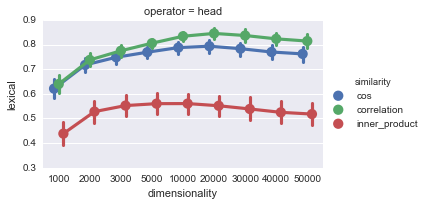

In [64]:
t.plot_interaction(results[results.index.get_level_values('operator') == 'head']['max'], feature_ablation_lexical.index[0], 'lexical')

In [65]:
assert feature_ablation_lexical.index[0] == 'similarity'

r = results[results.index.get_level_values('operator') == 'head']['max'].reset_index()

heuristics_selection_collection_lexical[0] = r.loc[
    r['similarity'] == 'correlation'
]

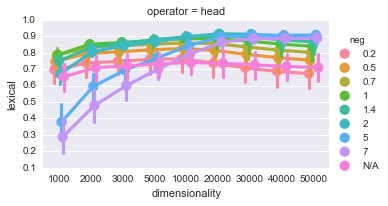

In [66]:
t.plot_interaction(heuristics_selection_collection_lexical[0], feature_ablation_lexical.index[1], 'lexical')

In [67]:
assert feature_ablation_lexical.index[1] == 'neg'

r = heuristics_selection_collection_lexical[0]

heuristics_selection_collection_lexical[1] =  r.loc[
    (~(r['dimensionality'] < 20000) | (r['neg'] == 1)) &
    (~(r['dimensionality'] >= 20000) | (r['neg'] == 2)) &

    True
]

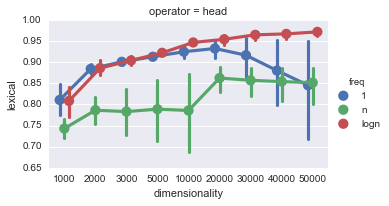

In [68]:
t.plot_interaction(heuristics_selection_collection_lexical[1], feature_ablation_lexical.index[2], 'lexical')

In [69]:
assert feature_ablation_lexical.index[2] == 'freq'

r = heuristics_selection_collection_lexical[1]

heuristics_selection_collection_lexical[2] =  r.loc[
    r['freq'] == 'logn'
]

In [70]:
assert feature_ablation_lexical.index[3] == 'dimensionality'

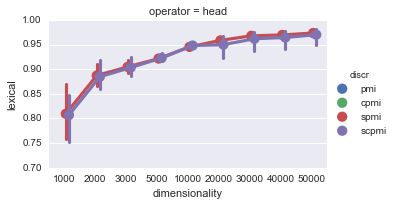

In [71]:
t.plot_interaction(heuristics_selection_collection_lexical[2], feature_ablation_lexical.index[4], 'lexical')

In [72]:
assert feature_ablation_lexical.index[4] == 'discr'

r = heuristics_selection_collection_lexical[2]

heuristics_selection_collection_lexical[3] =  r.loc[
    r['discr'] == 'scpmi'
]

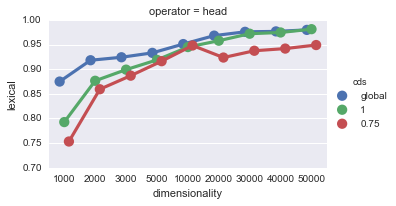

In [73]:
t.plot_interaction(heuristics_selection_collection_lexical[3], feature_ablation_lexical.index[5], 'lexical')

In [74]:
assert feature_ablation_lexical.index[5] == 'cds'

r = heuristics_selection_collection_lexical[3]

heuristics_selection_collection_lexical[4] =  r.loc[
    r['cds'] == 'global'
]

In [75]:
assert len(feature_ablation_lexical) == 6

In [76]:
heuristics_selection_lexical = heuristics_selection_collection_lexical[4].set_index(['operator', 'dimensionality'], drop=False)
heuristics_selection_lexical['selection'] = 'heuristics'

In [77]:
max_selection_lexical.sort_index().round(
    {
        'men': 3,
        'SimLex999': 3,
        'lexical': 3,
    }
).loc['head'].to_latex(
    'figures/lexical-max-selection.tex',
    columns=[
        'SimLex999',
        'men',
        'lexical',
        'freq',
        'discr',
        'cds',
        'neg',
        'similarity',
    ],
)

In [78]:
heuristics_selection_lexical.sort_index().round(
    {
        'men': 3,
        'SimLex999': 3,
        'lexical': 3,
    }
).loc['head'].to_latex(
    'figures/lexical-heuristics-selection.tex',
    columns=[
        'SimLex999',
        'men',
        'lexical',
        'freq',
        'discr',
        'cds',
        'neg',
        'similarity',
    ],
)

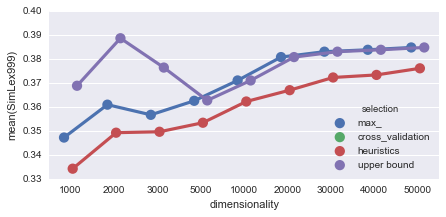

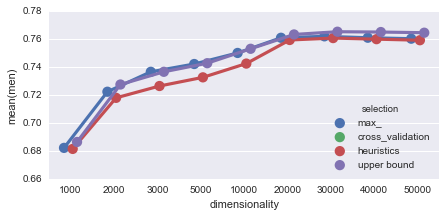

In [79]:
f, ax = plt.subplots(figsize=(7, 3))
t.plot_parameter_selection_comparison(
    [
        max_selection_lexical,
        heuristics_selection_lexical,
        
        max_selection_simlex.assign(selection='upper bound')
    ],
    'SimLex999',
    'SimLex999',
    ax=ax,
)
f.savefig('figures/lexical-results-SimLex999.pdf')

f, ax = plt.subplots(figsize=(7, 3))
t.plot_parameter_selection_comparison(
    [
        max_selection_lexical,
        heuristics_selection_lexical,

        max_selection_men.assign(selection='upper bound'),
    ],
    'men',
    'men',
    ax=ax,
)
f.savefig('figures/lexical-results-men.pdf')

In [80]:
'Lexical on SimLex999 (max): {:.3f}'.format(
    t.average_error(
        max_selection_simlex,
        max_selection_lexical,
        'SimLex999',
    ),
)

'Lexical on SimLex999 (max): 0.020'

In [81]:
'Lexical on men (max): {:.3f}'.format(
    t.average_error(
        max_selection_men,
        max_selection_lexical,
        'men',
    ),
)

'Lexical on men (max): 0.004'

In [82]:
'Lexical on SimLex999 (heuristics): {:.3f}'.format(
    t.average_error(
        max_selection_simlex,
        heuristics_selection_lexical,
        'SimLex999',
    ),
)

'Lexical on SimLex999 (heuristics): 0.048'

In [83]:
'Lexical on men (heuristics): {:.3f}'.format(
    t.average_error(
        max_selection_men,
        heuristics_selection_lexical,
        'men',
    ),
)

'Lexical on men (heuristics): 0.010'

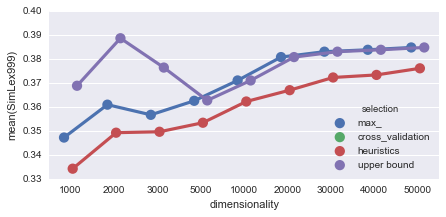

In [84]:
f, ax = plt.subplots(figsize=(7, 3))
t.plot_parameter_selection_comparison(
    [
        max_selection_lexical,
        heuristics_selection_lexical,

        max_selection_simlex.assign(selection='upper bound')
    ],
    'lexical',
    'SimLex999',
    ax=ax,
)
# f.savefig('figures/SimLex999-transfer.pdf')

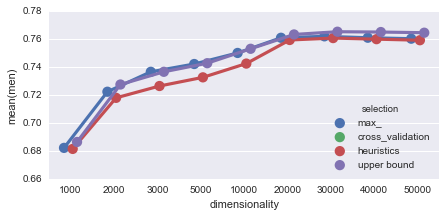

In [85]:
f, ax = plt.subplots(figsize=(7, 3))
t.plot_parameter_selection_comparison(
    [
        max_selection_lexical,
        heuristics_selection_lexical,

        max_selection_men.assign(selection='upper bound')
    ],
    'lexical',
    'men',
    ax=ax,
)
# f.savefig('figures/SimLex999-transfer.pdf')

# Compositional

## Max

In [86]:
max_selection_ks14 = t.plot_selection(
    results[results['max', 'KS14'].notnull()],
    dataset='KS14',
    selector_function=t.max_('GS11', 'PhraseRel'),
    plot=False,
)

In [87]:
max_selection_gs11 = t.plot_selection(
    results[results['max', 'GS11'].notnull()],
    dataset='GS11',
    selector_function=t.max_('KS14', 'PhraseRel'),
    plot=False,
)

In [88]:
max_selection_phraserel = t.plot_selection(
    results,#[results['max', 'PhraseRel'].notnull()],
    dataset='PhraseRel',
    selector_function=t.max_('KS14', 'GS11'),
    plot=False,
)

## Cross-validation

In [89]:
cross_validation_selection_ks14 = t.plot_selection(
    results[results['max', 'KS14'].notnull()],
    dataset='KS14',
    selector_function=t.cross_validation('GS11', 'PhraseRel'),
    plot=False,
)

In [90]:
cross_validation_selection_gs11= t.plot_selection(
    results[results['max', 'GS11'].notnull()],
    dataset='GS11',
    selector_function=t.cross_validation('KS14', 'PhraseRel'),
    plot=False,
)

In [91]:
cross_validation_selection_phraserel = t.plot_selection(
    results[results['max', 'PhraseRel'].notnull()],
    dataset='PhraseRel',
    selector_function=t.cross_validation('KS14', 'GS11'),
    plot=False,
)

## Heuristics 

In [92]:
compositional_parameters = parameters + ['operator']

## KS14

In [100]:
'{:.3f}'.format(
        t.anova(
        response='KS14',
        predictors=compositional_parameters,
        data=results.loc[['add', 'head', 'mult', 'kron']],
    ).rsquared_adj
)

'0.794'

In [102]:
feature_ablation_ks14 = t.calculate_feature_ablation(
    responses=(
        'KS14',
    ),
    predictors=compositional_parameters,
    data=results.loc[['add', 'head', 'mult', 'kron']],
)

# feature_ablation.plot(kind='barh')#.get_figure().savefig('figures/emnlp2013_turk-parameter-ablation.pdf')
feature_ablation_ks14.sort_values(('partial R2', 'KS14'), ascending=False, inplace=True)

feature_ablation_ks14.round(3)

,partial R2
response,KS14
predictor,
neg,0.331
freq,0.307
operator,0.305
cds,0.136
similarity,0.061
discr,0.054
dimensionality,0.034


In [103]:
_ = feature_ablation_ks14.copy()
_.columns.names = ['', '']
(
    _['partial R2']
    .round(3)
    .to_latex('figures/ks14-ablation.tex')
)

In [104]:
heuristics_selection_collection_ks14 = {}

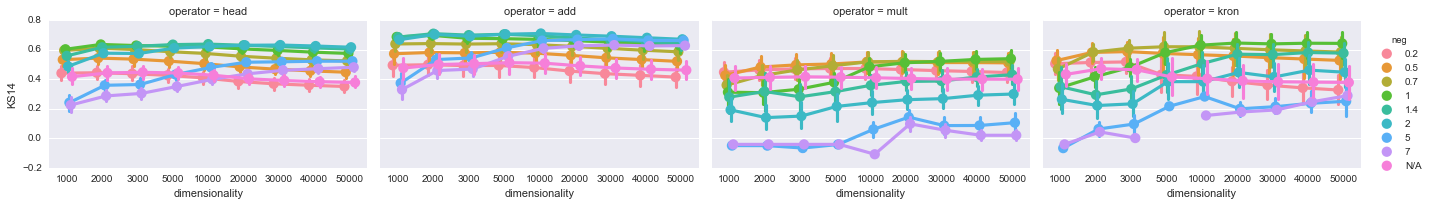

In [106]:
t.plot_interaction(results.loc[['add', 'head', 'mult', 'kron'], 'max'], feature_ablation_ks14.index[0], 'KS14')

In [107]:
assert feature_ablation_ks14.index[0] == 'neg'

r = results.loc[['add', 'head', 'mult', 'kron'], 'max'].reset_index()

heuristics_selection_collection_ks14[0] =  r.loc[
    (~((r['operator'] == 'head') & (r['dimensionality'] < 5000)) | ((r['neg'] == 1))) &
    (~((r['operator'] == 'head') & (r['dimensionality'] >= 5000) & (r['dimensionality'] < 30000)) | ((r['neg'] == 1.4))) &
    (~((r['operator'] == 'head') & (r['dimensionality'] >= 30000)) | ((r['neg'] == 2))) &

    (~((r['operator'] == 'add') & (r['dimensionality'] < 20000)) | ((r['neg'] == 1.4))) &
    (~((r['operator'] == 'add') & (r['dimensionality'] >= 20000)) | ((r['neg'] == 2))) &

    (~((r['operator'] == 'mult') & (r['dimensionality'] < 10000)) | ((r['neg'] == 0.5))) &
    (~((r['operator'] == 'mult') & (r['dimensionality'] >= 10000) & (r['dimensionality'] < 30000)) | ((r['neg'] == 0.7))) &
    (~((r['operator'] == 'mult') & (r['dimensionality'] >= 30000)) | ((r['neg'] == 1))) &

    (~((r['operator'] == 'kron') & (r['dimensionality'] < 3000)) | ((r['neg'] == 0.5))) &
    (~((r['operator'] == 'kron') & (r['dimensionality'] >= 3000) & (r['dimensionality'] < 20000)) | ((r['neg'] == 0.7))) &
    (~((r['operator'] == 'kron') & (r['dimensionality'] >= 20000)) | ((r['neg'] == 1))) &

    True
]

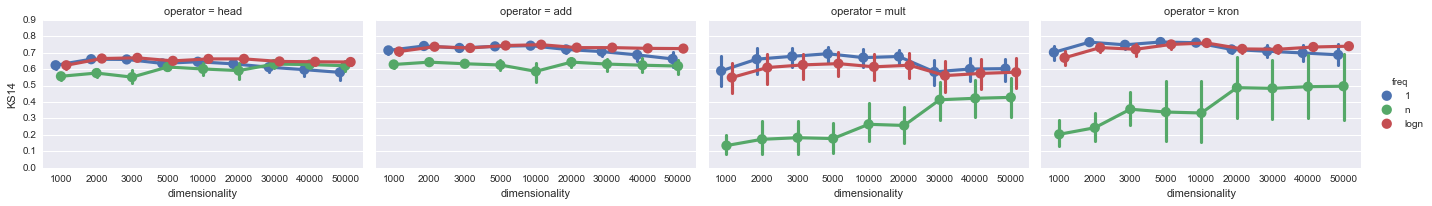

In [108]:
t.plot_interaction(heuristics_selection_collection_ks14[0], feature_ablation_ks14.index[1], 'KS14')

In [109]:
assert feature_ablation_ks14.index[1] == 'freq'

r = heuristics_selection_collection_ks14[0]

heuristics_selection_collection_ks14[1] =  r.loc[
    (~((r['operator'] == 'head')) | (r['freq'] == 'logn')) &

    (~((r['operator'] == 'add') & (r['dimensionality'] < 5000)) | ((r['freq'] == '1'))) &
    (~((r['operator'] == 'add') & (r['dimensionality'] >= 5000)) | ((r['freq'] == 'logn'))) &

    (~((r['operator'] == 'mult')) | (r['freq'] == '1')) &
     
    (~((r['operator'] == 'kron') & (r['dimensionality'] < 10000)) | ((r['freq'] == '1'))) &
    (~((r['operator'] == 'kron') & (r['dimensionality'] >= 10000)) | ((r['freq'] == 'logn'))) &

    True
]

# t.plot_interaction(heuristics_selection_collection_ks14[1], feature_ablation_ks14.index[1], 'KS14')

In [110]:
assert feature_ablation_ks14.index[2] == 'operator'

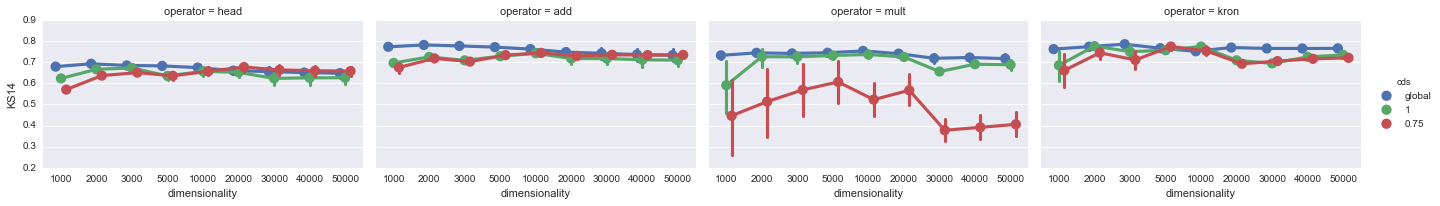

In [111]:
t.plot_interaction(heuristics_selection_collection_ks14[1], feature_ablation_ks14.index[3], 'KS14')

In [112]:
assert feature_ablation_ks14.index[3] == 'cds'

r = heuristics_selection_collection_ks14[1]

heuristics_selection_collection_ks14[2] =  r.loc[
    (~((r['operator'] == 'head') & (r['dimensionality'] < 20000)) | ((r['cds'] == 'global'))) &
    (~((r['operator'] == 'head') & (r['dimensionality'] >= 20000)) | ((r['cds'] == '0.75'))) &

    (~((r['operator'] == 'add')) | (r['cds'] == 'global')) &
    (~((r['operator'] == 'mult')) | (r['cds'] == 'global')) &
    (~((r['operator'] == 'kron')) | (r['cds'] == 'global')) &

    True
]

# t.plot_interaction(heuristics_selection_collection_ks14[1], feature_ablation_ks14.index[1], 'KS14')

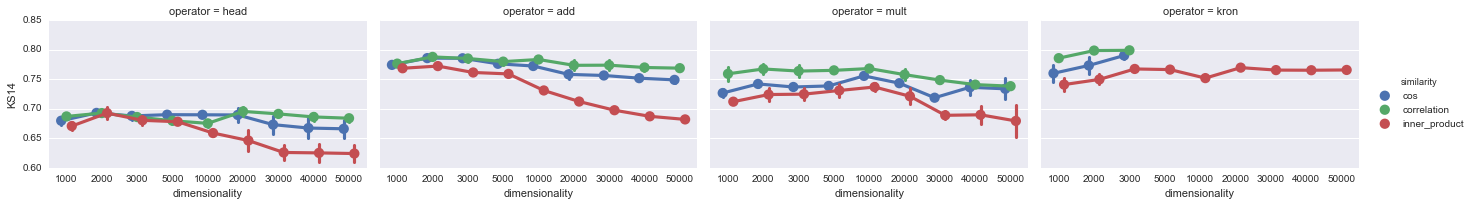

In [113]:
t.plot_interaction(heuristics_selection_collection_ks14[2], feature_ablation_ks14.index[4], 'KS14')

In [114]:
assert feature_ablation_ks14.index[4] == 'similarity'

r = heuristics_selection_collection_ks14[2]

heuristics_selection_collection_ks14[3] =  r.loc[
    (~((r['operator'] == 'head') &  (r['dimensionality'] < 20000)) | (r['similarity'] == 'cos')) &
    (~((r['operator'] == 'head') &  (r['dimensionality'] >= 20000)) | (r['similarity'] == 'correlation')) &

    (~((r['operator'] == 'add')) | (r['similarity'] == 'correlation')) &

    (~((r['operator'] == 'mult')) | (r['similarity'] == 'correlation')) &

    (~((r['operator'] == 'kron') &  (r['dimensionality'] < 5000)) | (r['similarity'] == 'correlation')) &
    (~((r['operator'] == 'kron') &  (r['dimensionality'] >= 5000)) | (r['similarity'] == 'inner_product')) &

    True
]

# t.plot_interaction(heuristics_selection_collection_ks14[3], feature_ablation_ks14.index[4], 'KS14')

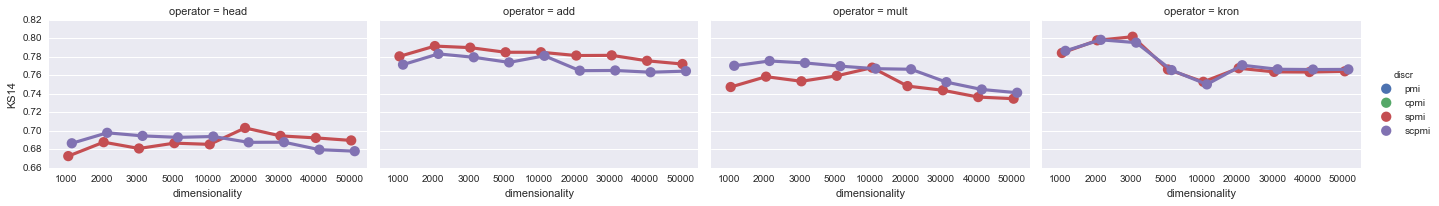

In [115]:
t.plot_interaction(heuristics_selection_collection_ks14[3], feature_ablation_ks14.index[5], 'KS14')

In [116]:
assert feature_ablation_ks14.index[5] == 'discr'

r = heuristics_selection_collection_ks14[3]

heuristics_selection_collection_ks14[4] =  r.loc[
    (~((r['operator'] == 'head') & (r['dimensionality'] < 20000)) | (r['discr'] == 'scpmi')) &
    (~((r['operator'] == 'head') & (r['dimensionality'] >= 20000)) | (r['discr'] == 'spmi')) &

    (~((r['operator'] == 'add')) | (r['discr'] == 'spmi')) &

    (~((r['operator'] == 'mult')) | (r['discr'] == 'scpmi')) &

    (~((r['operator'] == 'kron') & (r['dimensionality'] < 20000)) | (r['discr'] == 'spmi')) &
    (~((r['operator'] == 'kron') & (r['dimensionality'] >= 20000)) | (r['discr'] == 'scpmi')) &

    True
]

# t.plot_interaction(heuristics_selection_collection_ks14[4], feature_ablation_ks14.index[5], 'KS14')

In [117]:
assert feature_ablation_ks14.index[6] == 'dimensionality'

In [118]:
assert len(feature_ablation_ks14) == 7

In [119]:
heuristics_selection_ks14 = heuristics_selection_collection_ks14[4].set_index(['operator', 'dimensionality'], drop=False)
heuristics_selection_ks14['selection'] = 'heuristics'
heuristics_selection_ks14.sort_index(inplace=True)

In [120]:
t.plot_selection(
    heuristics_selection_ks14,
    dataset='KS14',
    selector_function='heuristics',
    plot=False,
)

In [121]:
pd.concat(
    [
        heuristics_selection_ks14.loc[
            ['head', '']
        ],        
        heuristics_selection_ks14.loc[
            ['add', 'mult']
        ],
        heuristics_selection_ks14.loc[
            ['kron', '']
        ],        
    ]
).round({'KS14': 3}).to_latex(
    'figures/ks14-heuristics-selection.tex',
    columns=[
        'KS14',
        'freq',
        'discr',
        'cds',
        'neg',
        'similarity',
    ],
)

## GS11

In [122]:
'{:.3f}'.format(
    t.anova(
        response='GS11',
        predictors=compositional_parameters,
        data=results.loc[['add', 'head', 'mult', 'kron']],
    ).rsquared_adj
)

'0.753'

In [123]:
feature_ablation_gs11 = t.calculate_feature_ablation(
    responses=(
        'GS11',
    ),
    predictors=compositional_parameters,
    data=results.loc[['add', 'head', 'mult', 'kron']],
)

# feature_ablation.plot(kind='barh')#.get_figure().savefig('figures/emnlp2013_turk-parameter-ablation.pdf')
feature_ablation_gs11.sort_values(('partial R2', 'GS11'), ascending=False, inplace=True)

feature_ablation_gs11.round(3)

,partial R2
response,GS11
predictor,
operator,0.367
freq,0.213
neg,0.179
similarity,0.088
cds,0.054
discr,0.039
dimensionality,0.039


In [124]:
_ = feature_ablation_gs11.copy()
_.columns.names = ['', '']
(
    _['partial R2']
    .round(3)
    .to_latex('figures/gs11-ablation.tex')
)

In [125]:
heuristics_selection_collection_gs11 = {}

In [126]:
assert feature_ablation_gs11.index[0] == 'operator'

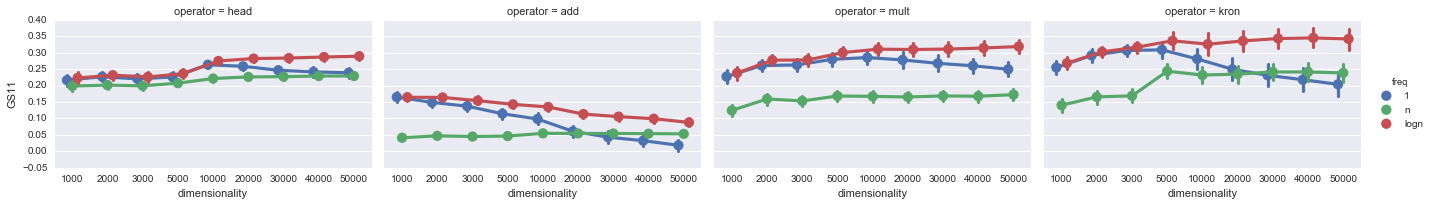

In [127]:
t.plot_interaction(results.loc[['add', 'head', 'mult', 'kron'], 'max'], feature_ablation_gs11.index[1], 'GS11')

In [128]:
assert feature_ablation_gs11.index[1] == 'freq'

r = results.loc[['add', 'head', 'mult', 'kron'], 'max'].reset_index()

heuristics_selection_collection_gs11[0] =  r.loc[
    (r['freq'] == 'logn')
]

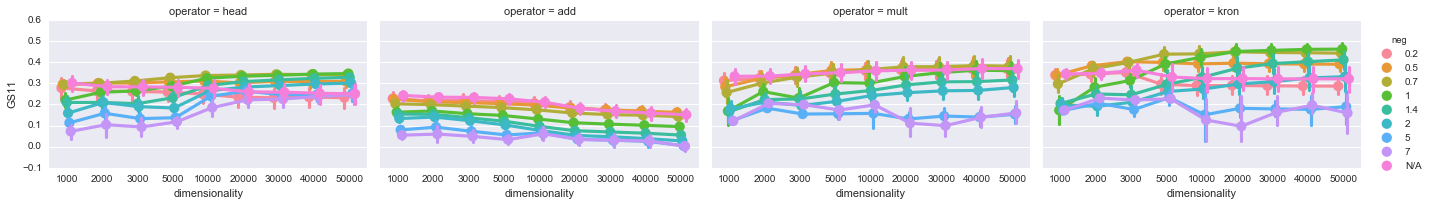

In [129]:
t.plot_interaction(heuristics_selection_collection_gs11[0], feature_ablation_gs11.index[2], 'GS11')

In [130]:
assert feature_ablation_gs11.index[2] == 'neg'

r = heuristics_selection_collection_gs11[0]

heuristics_selection_collection_gs11[1] =  r.loc[
    (~((r['operator'] == 'head') & (r['dimensionality'] < 3000)) | ((r['neg'] == 0.5))) &
    (~((r['operator'] == 'head') & (r['dimensionality'] >= 3000)) | ((r['neg'] == 0.7))) &

    (~((r['operator'] == 'add') & (r['dimensionality'] < 20000)) | ((r['neg'] == 'N/A'))) &
    (~((r['operator'] == 'add') & (r['dimensionality'] >= 20000)) | ((r['neg'] == 0.2))) &

    (~((r['operator'] == 'mult') & (r['dimensionality'] < 5000)) | ((r['neg'] == 'N/A'))) &
    (~((r['operator'] == 'mult') & (r['dimensionality'] >= 5000)) | ((r['neg'] == 0.7))) &

    (~((r['operator'] == 'kron') & (r['dimensionality'] < 20000)) | ((r['neg'] == 0.7))) &
    (~((r['operator'] == 'kron') & (r['dimensionality'] >= 20000)) | ((r['neg'] == 1))) &

    True
]

# t.plot_interaction(heuristics_selection_collection_gs11[1], feature_ablation_gs11.index[2], 'GS11')

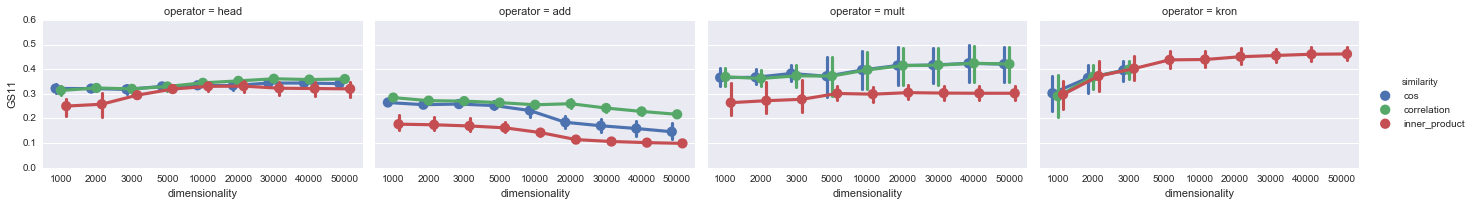

In [131]:
t.plot_interaction(heuristics_selection_collection_gs11[1], feature_ablation_gs11.index[3], 'GS11')

In [132]:
assert feature_ablation_gs11.index[3] == 'similarity'

r = heuristics_selection_collection_gs11[1]

heuristics_selection_collection_gs11[2] =  r.loc[
    (~((r['operator'] == 'head')) | ((r['similarity'] == 'cos'))) &
    (~((r['operator'] == 'add')) | ((r['similarity'] == 'correlation'))) &
    (~((r['operator'] == 'mult')) | ((r['similarity'] == 'cos'))) &
    (~((r['operator'] == 'kron')) | ((r['similarity'] == 'inner_product'))) &

    True
]

# t.plot_interaction(heuristics_selection_collection_gs11[2], feature_ablation_gs11.index[3], 'GS11')

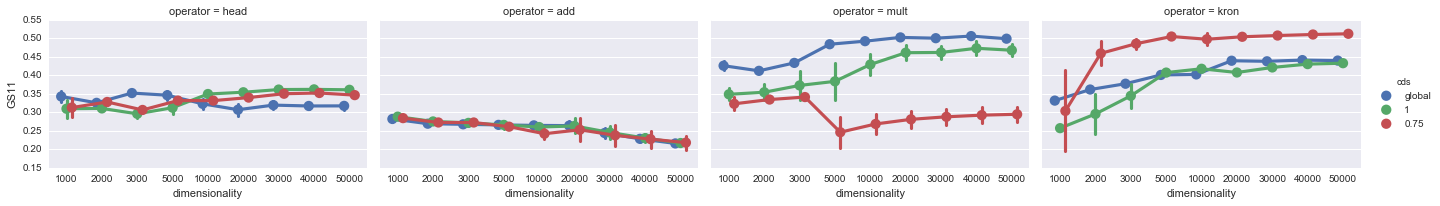

In [133]:
t.plot_interaction(heuristics_selection_collection_gs11[2], feature_ablation_gs11.index[4], 'GS11')

In [134]:
assert feature_ablation_gs11.index[4] == 'cds'

r = heuristics_selection_collection_gs11[2]

heuristics_selection_collection_gs11[3] =  r.loc[
    (~((r['operator'] == 'head') & (r['dimensionality'] < 10000)) | ((r['cds'] == 'global'))) &
    (~((r['operator'] == 'head') & (r['dimensionality'] >= 10000)) | ((r['cds'] == '1'))) &

    (~((r['operator'] == 'add') & (r['dimensionality'] < 20000)) | ((r['cds'] == '1'))) &
    (~((r['operator'] == 'add') & (r['dimensionality'] >= 20000)) | ((r['cds'] == '0.75'))) &

    (~((r['operator'] == 'mult')) | ((r['cds'] == 'global'))) &

    (~((r['operator'] == 'kron')) | ((r['cds'] == '0.75'))) &

    True
]

# t.plot_interaction(heuristics_selection_collection_gs11[3], feature_ablation_gs11.index[4], 'GS11')

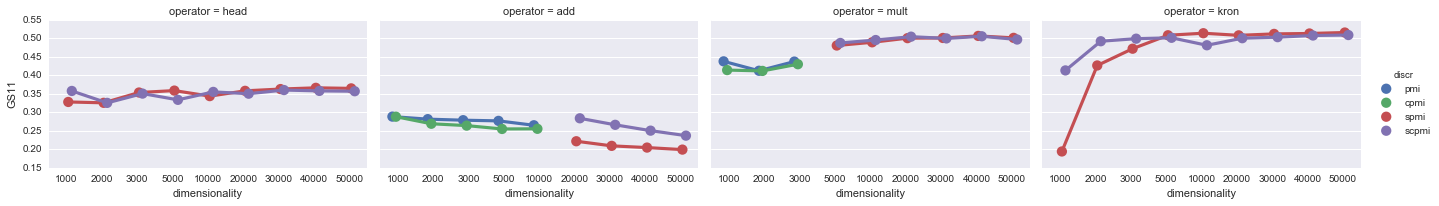

In [135]:
t.plot_interaction(heuristics_selection_collection_gs11[3], feature_ablation_gs11.index[5], 'GS11')

In [136]:
assert feature_ablation_gs11.index[5] == 'discr'

r = heuristics_selection_collection_gs11[3]

heuristics_selection_collection_gs11[4] =  r.loc[
    (~((r['operator'] == 'head')) | ((r['discr'] == 'spmi'))) &

    (~((r['operator'] == 'add') & (r['dimensionality'] < 20000)) | ((r['discr'] == 'pmi'))) &
    (~((r['operator'] == 'add') & (r['dimensionality'] >= 20000)) | ((r['discr'] == 'scpmi'))) &

    (~((r['operator'] == 'mult') & (r['dimensionality'] < 5000)) | ((r['discr'] == 'pmi'))) &
    (~((r['operator'] == 'mult') & (r['dimensionality'] >= 5000)) | ((r['discr'] == 'scpmi'))) &

    (~((r['operator'] == 'kron') & (r['dimensionality'] < 5000)) | ((r['discr'] == 'scpmi'))) &
    (~((r['operator'] == 'kron') & (r['dimensionality'] >= 5000)) | ((r['discr'] == 'spmi'))) &

    True
]

# t.plot_interaction(heuristics_selection_collection_gs11[4], feature_ablation_gs11.index[5], 'GS11')

In [137]:
assert feature_ablation_gs11.index[6] == 'dimensionality'

In [138]:
assert len(feature_ablation_gs11) == 7

In [139]:
heuristics_selection_gs11 = heuristics_selection_collection_gs11[4].set_index(['operator', 'dimensionality'], drop=False)
heuristics_selection_gs11['selection'] = 'heuristics'
heuristics_selection_gs11.sort_index(inplace=True)

In [140]:
t.plot_selection(
    heuristics_selection_gs11,
    dataset='GS11',
    selector_function='heuristics',
    plot=False,
)

##  Phraserel

In [141]:
'{:.3f}'.format(
    t.anova(
        response='PhraseRel',
        predictors=compositional_parameters,
        data=results.loc[['add', 'head', 'mult', 'kron']],
    ).rsquared_adj
)

'0.822'

In [142]:
feature_ablation_phraserel = t.calculate_feature_ablation(
    responses=(
        'PhraseRel',
    ),
    predictors=compositional_parameters,
    data=results.loc[['add', 'head', 'mult', 'kron']],
)

# feature_ablation.plot(kind='barh')#.get_figure().savefig('figures/emnlp2013_turk-parameter-ablation.pdf')
feature_ablation_phraserel.sort_values(('partial R2', 'PhraseRel'), ascending=False, inplace=True)

feature_ablation_phraserel.round(3)

,partial R2
response,PhraseRel
predictor,
neg,0.579
operator,0.355
cds,0.075
freq,0.043
similarity,0.033
dimensionality,0.032
discr,0.021


In [143]:
_ = feature_ablation_phraserel.copy()
_.columns.names = ['', '']
(
    _['partial R2']
    .round(3)
    .to_latex('figures/phraserel-ablation.tex')
)

In [144]:
heuristics_selection_collection_phraserel = {}

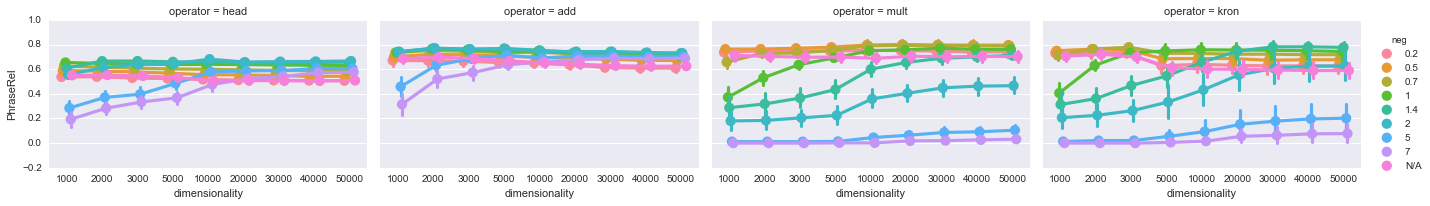

In [145]:
t.plot_interaction(results.loc[['add', 'head', 'mult', 'kron'], 'max'], feature_ablation_phraserel.index[0], 'PhraseRel')

In [146]:
assert feature_ablation_phraserel.index[0] == 'neg'

r = results.loc[['add', 'head', 'mult', 'kron'], 'max'].reset_index()

heuristics_selection_collection_phraserel[0] =  r.loc[
    (~((r['operator'] == 'head')) | ((r['neg'] == 1.4))) &
    (~((r['operator'] == 'add')) | ((r['neg'] == 2))) &
    (~((r['operator'] == 'mult')) | ((r['neg'] == 0.5))) &

    (~(((r['operator'] == 'kron') & (r['dimensionality'] < 5000))) | ((r['neg'] == 0.5))) &
    (~(((r['operator'] == 'kron') & (r['dimensionality'] >= 5000) & (r['dimensionality'] < 20000))) | ((r['neg'] == 1))) &
    (~(((r['operator'] == 'kron') & (r['dimensionality'] >= 20000))) | ((r['neg'] == 1.4))) &

    True
]

In [147]:
assert feature_ablation_phraserel.index[1] == 'operator'

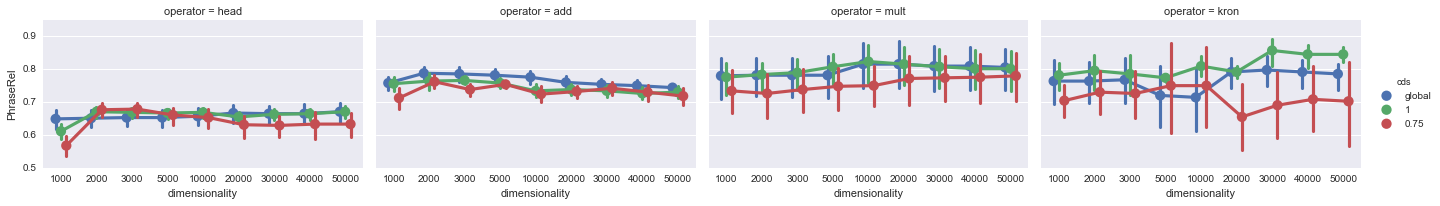

In [148]:
t.plot_interaction(heuristics_selection_collection_phraserel[0], feature_ablation_phraserel.index[2], 'PhraseRel')

In [149]:
assert feature_ablation_phraserel.index[2] == 'cds'

r = heuristics_selection_collection_phraserel[0]

heuristics_selection_collection_phraserel[1] =  r.loc[
    (~(((r['operator'] == 'head') & (r['dimensionality'] < 10000))) | ((r['cds'] == '0.75'))) &
    (~(((r['operator'] == 'head') & (r['dimensionality'] >= 10000))) | ((r['cds'] == 'global'))) &

    (~((r['operator'] == 'add')) | ((r['cds'] == 'global'))) &
    (~((r['operator'] == 'mult')) | ((r['cds'] == 'global'))) &
    (~((r['operator'] == 'kron')) | ((r['cds'] == '1'))) &

    True
]

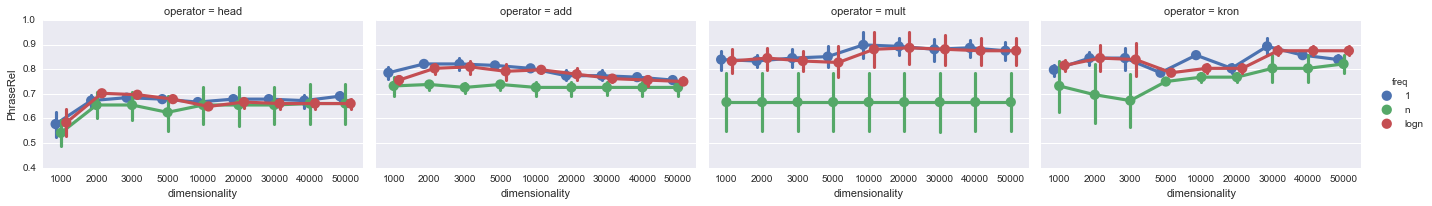

In [150]:
t.plot_interaction(heuristics_selection_collection_phraserel[1], feature_ablation_phraserel.index[3], 'PhraseRel')

In [151]:
assert feature_ablation_phraserel.index[3] == 'freq'

r = heuristics_selection_collection_phraserel[1]

heuristics_selection_collection_phraserel[2] =  r.loc[
    (~((r['operator'] == 'head')) | ((r['freq'] == 'n'))) &
    (~((r['operator'] == 'add')) | ((r['freq'] == '1'))) &
    (~((r['operator'] == 'mult')) | ((r['freq'] == 'logn'))) &

    (~(((r['operator'] == 'kron') & (r['dimensionality'] < 5000))) | ((r['freq'] == 'logn'))) &
    (~(((r['operator'] == 'kron') & (r['dimensionality'] >= 5000))) | ((r['freq'] == '1'))) &

    True
]

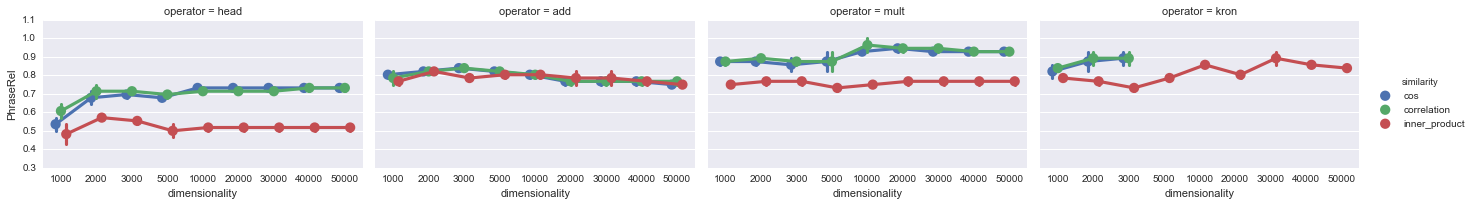

In [158]:
t.plot_interaction(heuristics_selection_collection_phraserel[2], feature_ablation_phraserel.index[4], 'PhraseRel')

In [159]:
assert feature_ablation_phraserel.index[4] == 'similarity'

r = heuristics_selection_collection_phraserel[2]

heuristics_selection_collection_phraserel[3] =  r.loc[
    (~(((r['operator'] == 'head') & (r['dimensionality'] < 10000))) | ((r['similarity'] == 'correlation'))) &
    (~(((r['operator'] == 'head') & (r['dimensionality'] >= 10000))) | ((r['similarity'] == 'cos'))) &

    (~(((r['operator'] == 'add') & (r['dimensionality'] < 20000))) | ((r['similarity'] == 'cos'))) &
    (~(((r['operator'] == 'add') & (r['dimensionality'] >= 20000))) | ((r['similarity'] == 'inner_product'))) &

    (~((r['operator'] == 'mult')) | ((r['similarity'] == 'correlation'))) &

    (~(((r['operator'] == 'kron') & (r['dimensionality'] < 5000))) | ((r['similarity'] == 'correlation'))) &
    (~(((r['operator'] == 'kron') & (r['dimensionality'] >= 5000))) | ((r['similarity'] == 'inner_product'))) &

    True
]

In [160]:
assert feature_ablation_phraserel.index[5] == 'dimensionality'

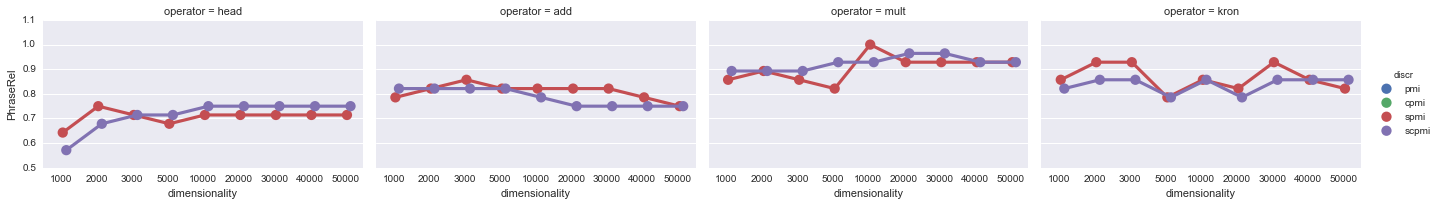

In [161]:
t.plot_interaction(heuristics_selection_collection_phraserel[3], feature_ablation_phraserel.index[6], 'PhraseRel')

In [162]:
assert feature_ablation_phraserel.index[6] == 'discr'

r = heuristics_selection_collection_phraserel[3]

heuristics_selection_collection_phraserel[4] =  r.loc[
    (~(((r['operator'] == 'head') & (r['dimensionality'] < 5000))) | ((r['discr'] == 'spmi'))) &
    (~(((r['operator'] == 'head') & (r['dimensionality'] >= 5000))) | ((r['discr'] == 'scpmi'))) &

    (~((r['operator'] == 'add')) | ((r['discr'] == 'spmi'))) &
    (~((r['operator'] == 'mult')) | ((r['discr'] == 'scpmi'))) &
    (~((r['operator'] == 'kron')) | ((r['discr'] == 'spmi'))) &

    True
]

In [163]:
assert len(feature_ablation_phraserel) == 7

In [164]:
heuristics_selection_phraserel = heuristics_selection_collection_phraserel[4].set_index(['operator', 'dimensionality'], drop=False)
heuristics_selection_phraserel['selection'] = 'heuristics'
heuristics_selection_phraserel.sort_index(inplace=True)

## Compositional comparison 

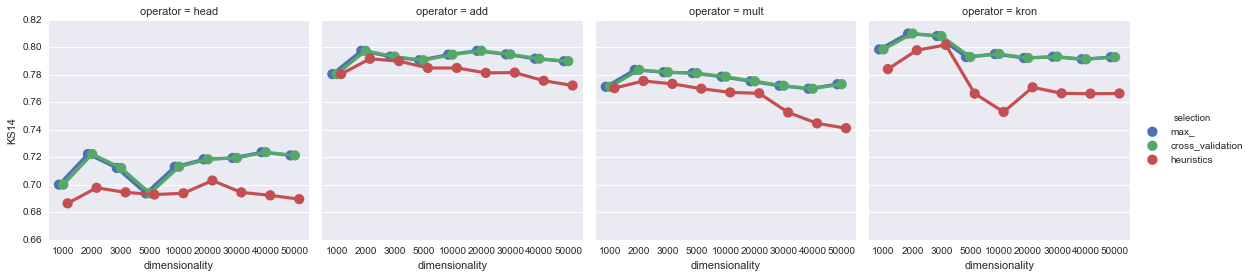

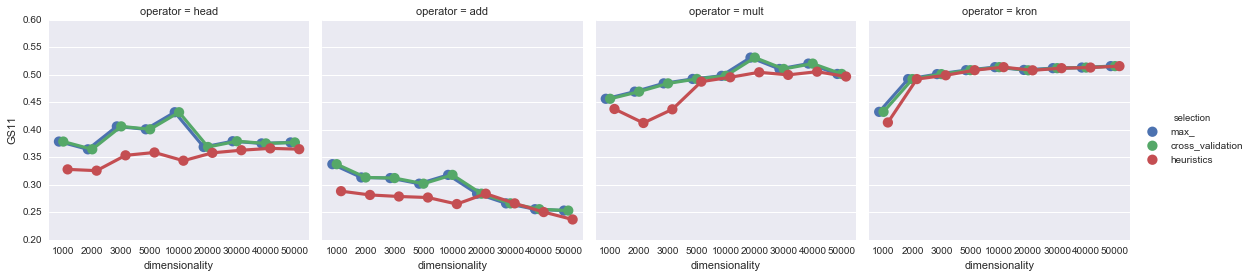

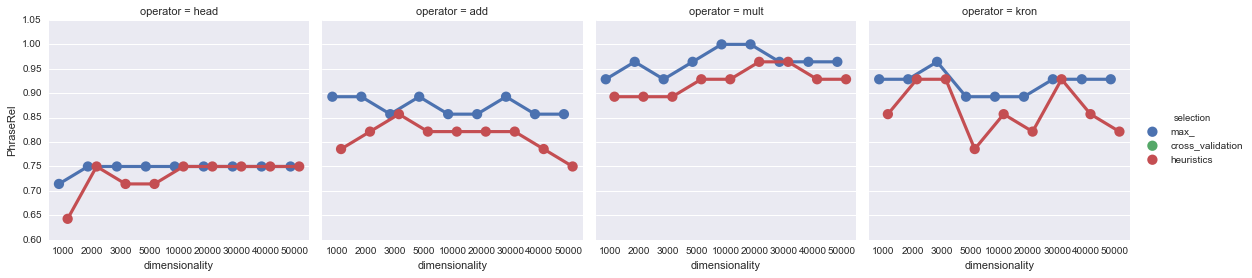

In [165]:
t.plot_parameter_selection_comparison(
    [
        max_selection_ks14,
        cross_validation_selection_ks14,
        heuristics_selection_ks14,
    ],
    'KS14',
    col='operator',
).fig.savefig('figures/ks14-results.pdf')
    
t.plot_parameter_selection_comparison(
    [
        max_selection_gs11,
        cross_validation_selection_gs11,
        heuristics_selection_gs11,
    ],
    'GS11',
    col='operator',
).fig.savefig('figures/gs11-results.pdf')

t.plot_parameter_selection_comparison(
    [
        max_selection_phraserel,
        #cross_validation_selection_phraserel,
        heuristics_selection_phraserel,
    ],
    'PhraseRel',
    col='operator',
).fig.savefig('figures/phraserel-results.pdf')

In [166]:
pd.concat(
    [
        max_selection_gs11.loc[
            ['head']
        ],        
        max_selection_gs11.loc[
            ['add', 'mult']
        ],
        max_selection_gs11.loc[
            ['kron']
        ],        
    ]
).round({'GS11': 3}).to_latex(
    'figures/gs11-max-selection.tex',
    columns=[
        'GS11',
        'freq',
        'discr',
        'cds',
        'neg',
        'similarity',
    ],
)

In [167]:
pd.concat(
    [
        heuristics_selection_gs11.loc[
            ['head', '']
        ],        
        heuristics_selection_gs11.loc[
            ['add', 'mult']
        ],
        heuristics_selection_gs11.loc[
            ['kron', '']
        ],        
    ]
).round({'GS11': 3}).to_latex(
    'figures/gs11-heuristics-selection.tex',
    columns=[
        'GS11',
        'freq',
        'discr',
        'cds',
        'neg',
        'similarity',
    ],
)

In [168]:
pd.concat(
    [
        max_selection_phraserel.loc[
            ['head']
        ],        
        max_selection_phraserel.loc[
            ['add', 'mult']
        ],
        max_selection_phraserel.loc[
            ['kron']
        ],        
    ]
).round({'PhraseRel': 3}).to_latex(
    'figures/phraserel-max-selection.tex',
    columns=[
        'PhraseRel',
        'freq',
        'discr',
        'cds',
        'neg',
        'similarity',
    ],
)

In [169]:
pd.concat(
    [
        heuristics_selection_phraserel.loc[
            ['head', '']
        ],        
        heuristics_selection_phraserel.loc[
            ['add', 'mult']
        ],
        heuristics_selection_phraserel.loc[
            ['kron', '']
        ],        
    ]
).round({'PhraseRel': 3}).to_latex(
    'figures/phraserel-heuristics-selection.tex',
    columns=[
        'PhraseRel',
        'freq',
        'discr',
        'cds',
        'neg',
        'similarity',
    ],
)

In [170]:
for operator in 'head', 'add', 'mult', 'kron':
    print(
        '{operator}: {:.3f}'.format(
            t.average_error(
                max_selection_phraserel.loc[operator],
                heuristics_selection_phraserel.loc[operator],
                'PhraseRel',
            ),
            operator=operator,
        )
    )

head: 0.022
add: 0.072
mult: 0.041
kron: 0.061


In [171]:
dataset_mapping = {
    'KS14': [
        max_selection_ks14,
        cross_validation_selection_ks14,
        heuristics_selection_ks14,
    ],
    'GS11': [
        max_selection_gs11,
        cross_validation_selection_gs11,
        heuristics_selection_gs11,
    ],
    'PhraseRel': [
        max_selection_phraserel,
        #cross_validation_selection_phraserel,
        heuristics_selection_phraserel,
    ],
}

In [172]:
for from_i, from_ in enumerate(('KS14', 'GS11', 'PhraseRel')):
    for to_i, to_ in enumerate(t for t in ('KS14', 'GS11', 'PhraseRel') if t != from_):
        for method_i, method in (0, 'max'), (-1, 'heuristics'):
            print(
                '{from_} -> {to_}, {method}: {:.3f}'.format(
                    t.average_error(
                        dataset_mapping[to_][0].loc[['head', 'add', 'mult', 'kron']],
                        dataset_mapping[from_][method_i].loc[['head', 'add', 'mult', 'kron']],
                        to_,
                    ),
                    from_=from_,
                    to_=to_,
                    method=method,
                )
            )

KS14 -> GS11, max: 0.335
KS14 -> GS11, heuristics: 0.238
KS14 -> PhraseRel, max: 0.093
KS14 -> PhraseRel, heuristics: 0.091
GS11 -> KS14, max: 0.119
GS11 -> KS14, heuristics: 0.106
GS11 -> PhraseRel, max: 0.133
GS11 -> PhraseRel, heuristics: 0.118
PhraseRel -> KS14, max: 0.134
PhraseRel -> KS14, heuristics: 0.136
PhraseRel -> GS11, max: 0.424
PhraseRel -> GS11, heuristics: 0.509


In [173]:
print(
    '{:.3f}'.format(
        t.average_error(
            max_selection_gs11.loc[['head', 'add', 'mult', 'kron']],
            heuristics_selection_ks14.loc[['head', 'add', 'mult', 'kron']],
            'GS11',
        ),
    )
)

0.238


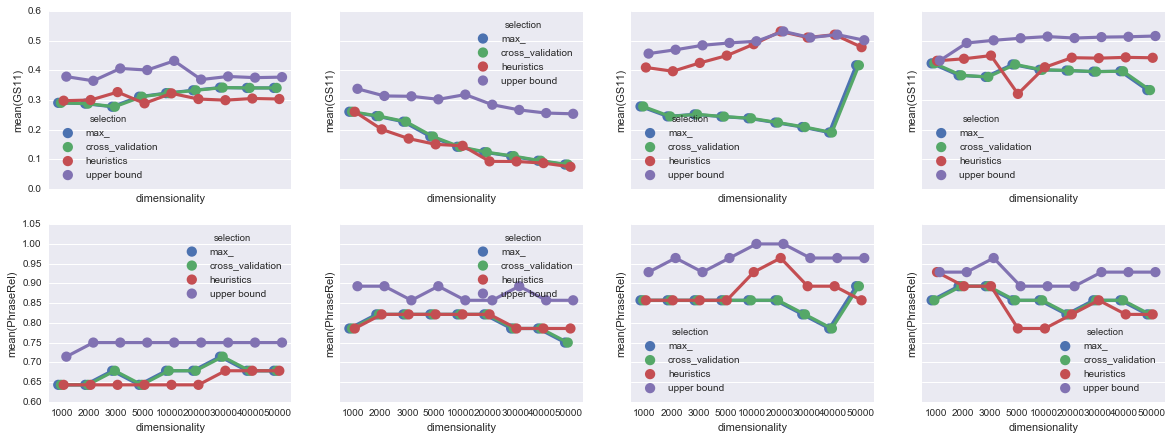

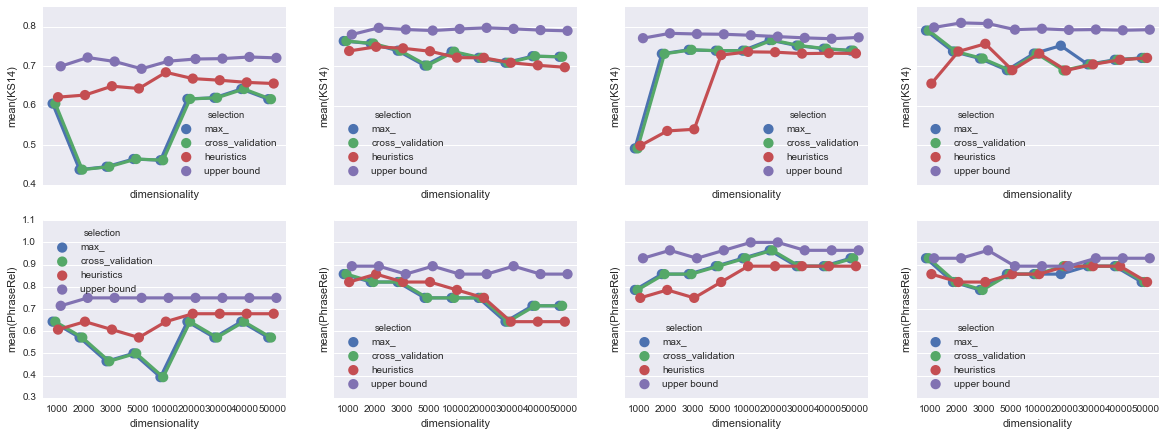

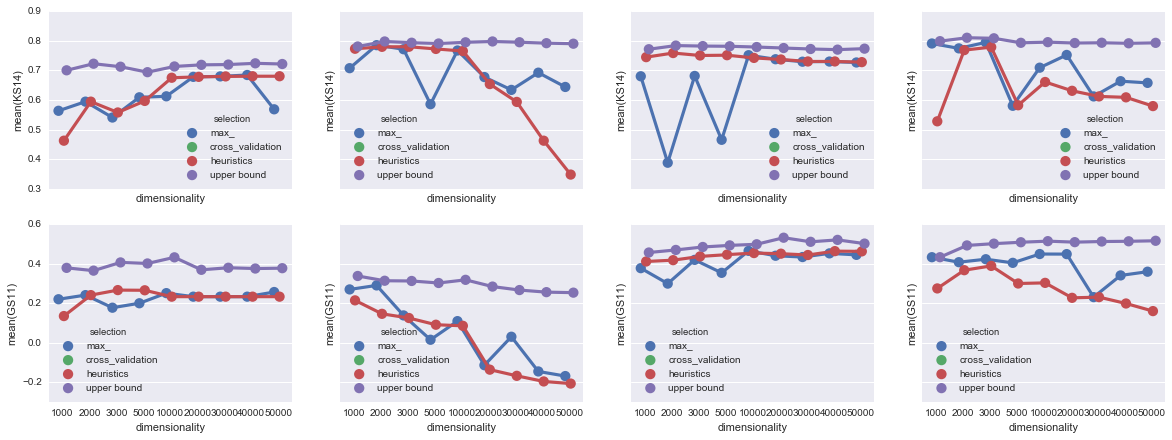

In [174]:
for from_i, from_ in enumerate(
    (
        'KS14',
        'GS11',
        'PhraseRel',
    )
):

    f, axarr = plt.subplots(
        2, 4,
        sharex=True,
        sharey='row',
        figsize=(2 * 10, 2 * 3.5),
    )

    for to_i, to_ in enumerate(t for t in ('KS14', 'GS11', 'PhraseRel') if t != from_):
        for operator_i, operator in enumerate(('head', 'add', 'mult', 'kron')):

            t.plot_parameter_selection_comparison(
                (
                    dataset_mapping[from_] +
                    [dataset_mapping[to_][0].assign(selection='upper bound')]
                ),
                from_,
                to_,
                ax=axarr[to_i, operator_i],
                operator=operator,
            )
            
    f.savefig('figures/{from_}-transfer.pdf'.format(from_=from_))

# Compositional

In [175]:
results['max', 'compositional'] = (
    (
        (results['max', 'KS14'] / results['max', 'KS14'].max()) +
        (results['max', 'GS11'] / results['max', 'GS11'].max()) +
        (results['max', 'PhraseRel'] / results['max', 'PhraseRel'].max())
    ) / 3
)

In [176]:
max_selection_compositional = t.plot_selection(
    results[
        results['max', 'KS14'].notnull() &
        results['max', 'GS11'].notnull()
    ],
    dataset='compositional',
    selector_function=t.max_('KS14', 'GS11', 'PhraseRel'),
    plot=False,
)

In [177]:
pd.concat(
    [
        max_selection_compositional.loc[
            ['head']
        ],        
        max_selection_compositional.loc[
            ['add', 'mult']
        ],
        max_selection_compositional.loc[
            ['kron']
        ],        
    ]
).round({'KS14': 3, 'GS11': 3, 'PhraseRel': 3, 'compositional': 3}).to_latex(
    'figures/compositional-max-selection.tex',
    columns=[
        'KS14',
        'GS11',
        'PhraseRel',
        'compositional',
        'freq',
        'discr',
        'cds',
        'neg',
        'similarity',
    ],
)

In [178]:
'{:.3f}'.format(
    t.anova(
        response='compositional',
        predictors=compositional_parameters,
        data=results.loc[['add', 'head', 'mult', 'kron']],
    ).rsquared_adj
)

'0.769'

In [180]:
feature_ablation_compositional = t.calculate_feature_ablation(
    responses=(
        'compositional',
    ),
    predictors=compositional_parameters,
    data=results.loc[['add', 'head', 'mult', 'kron']],
)

# feature_ablation.plot(kind='barh')#.get_figure().savefig('figures/emnlp2013_turk-parameter-ablation.pdf')
feature_ablation_compositional.sort_values(('partial R2', 'compositional'), ascending=False, inplace=True)

feature_ablation_compositional.round(3)

,partial R2
response,compositional
predictor,
neg,0.399
freq,0.294
operator,0.213
cds,0.147
similarity,0.080
discr,0.060
dimensionality,0.055


In [181]:
_ = feature_ablation_compositional.copy()
_.columns.names = ['', '']
(
    _['partial R2']
    .round(3)
    .to_latex('figures/compositional-ablation.tex')
)

In [182]:
heuristics_selection_collection_compositional = {}

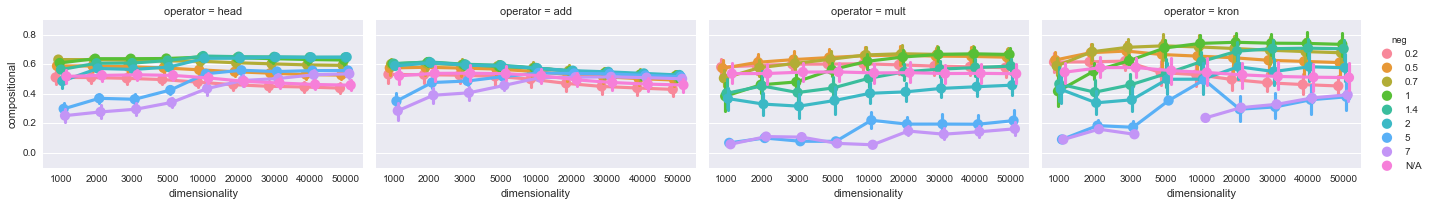

In [183]:
t.plot_interaction(results.loc[['add', 'head', 'mult', 'kron'], 'max'], feature_ablation_compositional.index[0], 'compositional')

In [184]:
assert feature_ablation_compositional.index[0] == 'neg'

r = results.loc[['add', 'head', 'mult', 'kron'], 'max'].reset_index()

heuristics_selection_collection_compositional[0] =  r.loc[
    (~(((r['operator'] == 'head') & (r['dimensionality'] < 10000))) | ((r['neg'] == 1))) &
    (~(((r['operator'] == 'head') & (r['dimensionality'] >= 10000))) | ((r['neg'] == 1.4))) &

    (~((r['operator'] == 'add')) | ((r['neg'] == 1))) &

    (~(((r['operator'] == 'mult') & (r['dimensionality'] < 10000))) | ((r['neg'] == 0.5))) &
    (~(((r['operator'] == 'mult') & (r['dimensionality'] >= 10000))) | ((r['neg'] == 0.7))) &

    (~(((r['operator'] == 'kron') & (r['dimensionality'] < 10000))) | ((r['neg'] == 0.7))) &
    (~(((r['operator'] == 'kron') & (r['dimensionality'] >= 10000))) | ((r['neg'] == 1))) &

    True
]

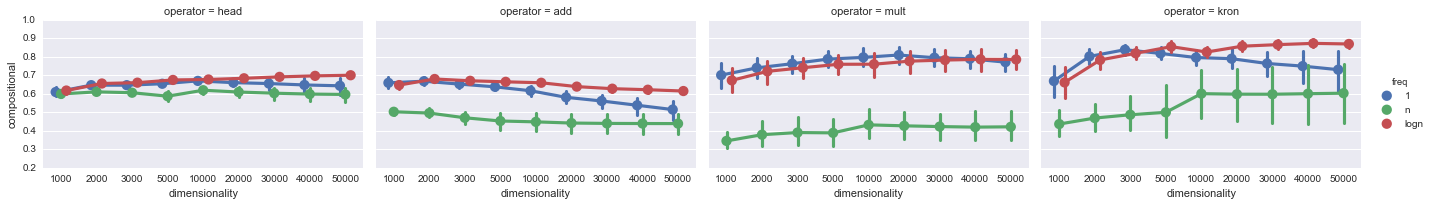

In [185]:
t.plot_interaction(heuristics_selection_collection_compositional[0], feature_ablation_compositional.index[1], 'compositional')

In [186]:
assert feature_ablation_compositional.index[1] == 'freq'

r = heuristics_selection_collection_compositional[0]

heuristics_selection_collection_compositional[1] =  r.loc[
    (~((r['operator'] == 'head')) | ((r['freq'] == 'logn'))) &
    (~((r['operator'] == 'add')) | ((r['freq'] == 'logn'))) &
    (~((r['operator'] == 'mult')) | ((r['freq'] == '1'))) &

    (~(((r['operator'] == 'kron') & (r['dimensionality'] < 5000))) | ((r['freq'] == '1'))) &
    (~(((r['operator'] == 'kron') & (r['dimensionality'] >= 5000))) | ((r['freq'] == 'logn'))) &

    True
]

In [187]:
assert feature_ablation_compositional.index[2] == 'operator'

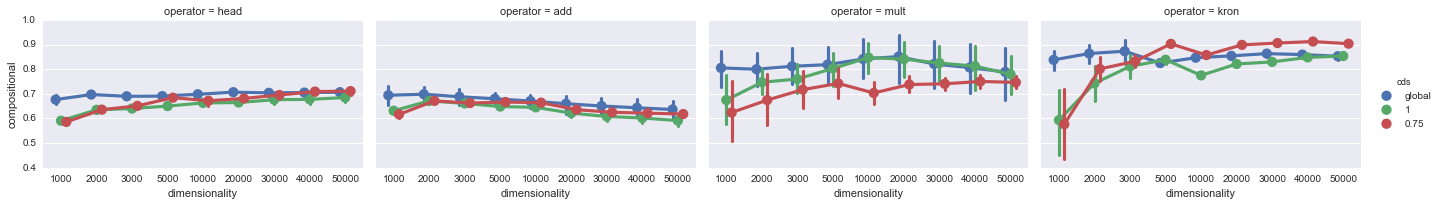

In [188]:
t.plot_interaction(heuristics_selection_collection_compositional[1], feature_ablation_compositional.index[3], 'compositional')

In [189]:
assert feature_ablation_compositional.index[3] == 'cds'

r = heuristics_selection_collection_compositional[1]

heuristics_selection_collection_compositional[2] =  r.loc[
    (~((r['operator'] == 'head')) | ((r['cds'] == 'global'))) &
    (~((r['operator'] == 'add')) | ((r['cds'] == 'global'))) &
    (~((r['operator'] == 'mult')) | ((r['cds'] == 'global'))) &

    (~(((r['operator'] == 'kron') & (r['dimensionality'] < 5000))) | ((r['cds'] == 'global'))) &
    (~(((r['operator'] == 'kron') & (r['dimensionality'] >= 5000))) | ((r['cds'] == '0.75'))) &

    True
]

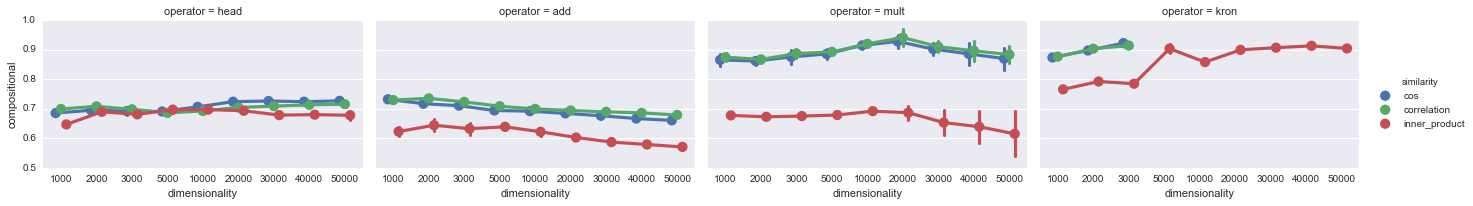

In [190]:
t.plot_interaction(heuristics_selection_collection_compositional[2], feature_ablation_compositional.index[4], 'compositional')

In [191]:
assert feature_ablation_compositional.index[4] == 'similarity'

r = heuristics_selection_collection_compositional[2]

heuristics_selection_collection_compositional[3] =  r.loc[
    (~(((r['operator'] == 'head') & (r['dimensionality'] < 5000))) | ((r['similarity'] == 'correlation'))) &
    (~(((r['operator'] == 'head') & (r['dimensionality'] >= 5000))) | ((r['similarity'] == 'cos'))) &

    (~((r['operator'] == 'add')) | ((r['similarity'] == 'correlation'))) &
    (~((r['operator'] == 'mult')) | ((r['similarity'] == 'correlation'))) &

    (~(((r['operator'] == 'kron') & (r['dimensionality'] < 5000))) | ((r['similarity'] == 'correlation'))) &
    (~(((r['operator'] == 'kron') & (r['dimensionality'] >= 5000))) | ((r['similarity'] == 'inner_product'))) &

    True
]

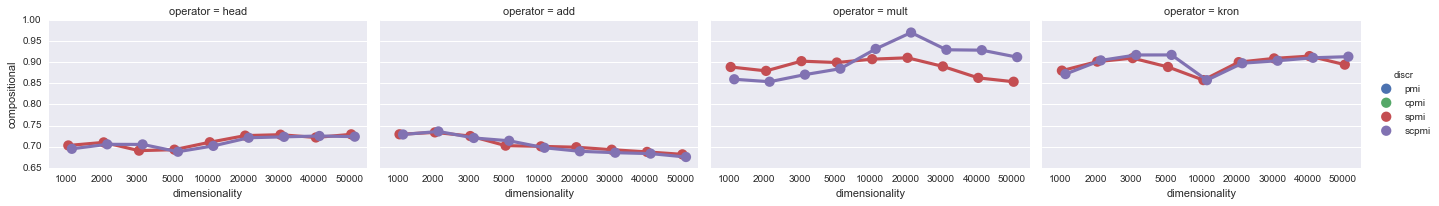

In [192]:
t.plot_interaction(heuristics_selection_collection_compositional[3], feature_ablation_compositional.index[5], 'compositional')

In [193]:
assert feature_ablation_compositional.index[5] == 'discr'

r = heuristics_selection_collection_compositional[3]

heuristics_selection_collection_compositional[4] =  r.loc[
    (~((r['operator'] == 'head')) | ((r['discr'] == 'spmi'))) &
    (~((r['operator'] == 'add')) | ((r['discr'] == 'spmi'))) &

    (~(((r['operator'] == 'mult') & (r['dimensionality'] < 10000))) | ((r['discr'] == 'spmi'))) &
    (~(((r['operator'] == 'mult') & (r['dimensionality'] >= 10000))) | ((r['discr'] == 'scpmi'))) &

    (~(((r['operator'] == 'kron') & (r['dimensionality'] < 10000))) | ((r['discr'] == 'scpmi'))) &
    (~(((r['operator'] == 'kron') & (r['dimensionality'] >= 10000))) | ((r['discr'] == 'spmi'))) &

    True
]

In [194]:
assert feature_ablation_compositional.index[6] == 'dimensionality'

In [195]:
assert len(feature_ablation_compositional) == 7

In [196]:
heuristics_selection_compositional = heuristics_selection_collection_compositional[4].set_index(['operator', 'dimensionality'], drop=False)
heuristics_selection_compositional['selection'] = 'heuristics'
heuristics_selection_compositional.sort_index(inplace=True)

In [197]:
dataset_mapping['compositional'] = (
    max_selection_compositional,
    heuristics_selection_compositional,
)

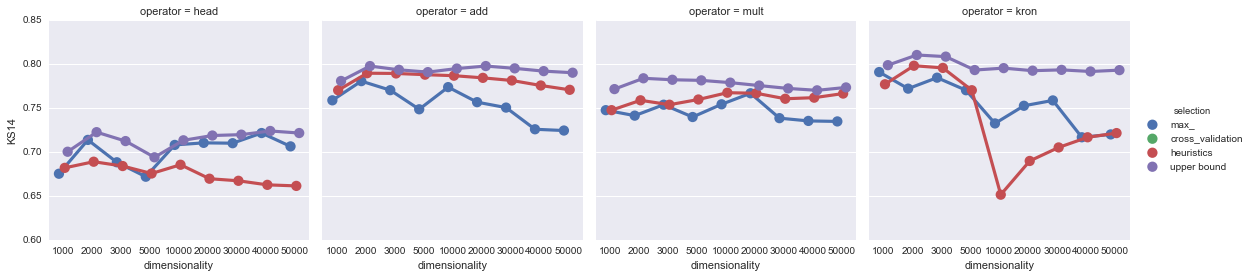

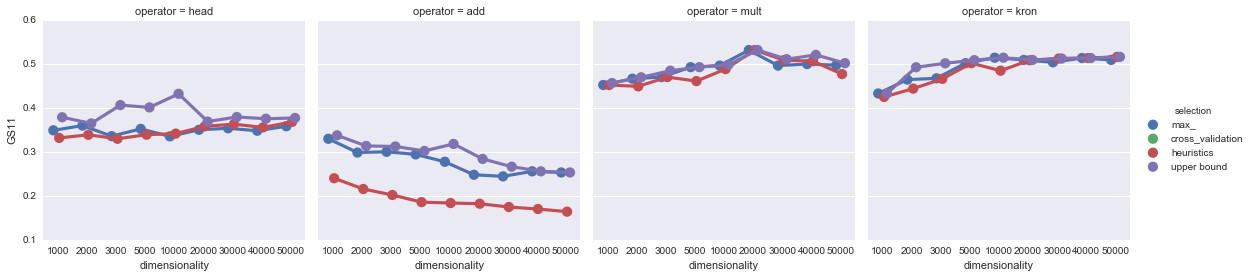

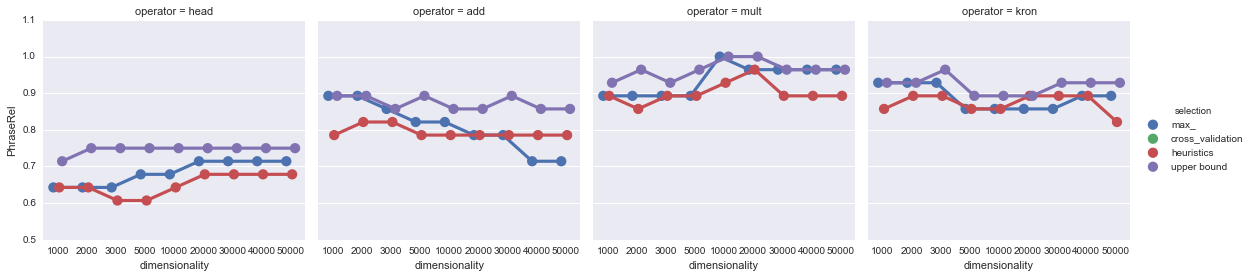

In [198]:
t.plot_parameter_selection_comparison(
    [
        max_selection_compositional,
        heuristics_selection_compositional,
        
        max_selection_ks14.assign(selection='upper bound')
    ],
    'KS14',
    'KS14',
    col='operator',

).fig.savefig('figures/compositional-results-ks14.pdf')

t.plot_parameter_selection_comparison(
    [
        max_selection_compositional,
        heuristics_selection_compositional,
        
        max_selection_gs11.assign(selection='upper bound'),
        max_selection_lexical.assign(selection='upper bound1', operator='add')
    ],
    'GS11',
    'GS11',
    col='operator',

).fig.savefig('figures/compositional-results-gs11.pdf')

t.plot_parameter_selection_comparison(
    [
        max_selection_compositional,
        heuristics_selection_compositional,
        
        max_selection_phraserel.assign(selection='upper bound')
    ],
    'PhraseRel',
    'PhraseRel',
    col='operator',

).fig.savefig('figures/compositional-results-phraserel.pdf')

In [199]:
pd.concat(
    [
        heuristics_selection_compositional.loc[
            ['head', '']
        ],        
        heuristics_selection_compositional.loc[
            ['add', 'mult']
        ],
        heuristics_selection_compositional.loc[
            ['kron', '']
        ],        
    ]
).round({'KS14': 3, 'GS11': 3, 'PhraseRel': 3, 'compositional': 3}).to_latex(
    'figures/compositional-heuristics-selection.tex',
    columns=[
        'KS14',
        'GS11',
        'PhraseRel',
        'compositional',
        'freq',
        'discr',
        'cds',
        'neg',
        'similarity',
    ],
)

In [200]:
for to_i, to_ in enumerate(('KS14', 'GS11', 'PhraseRel')):
    for method_i, method in (0, 'max'), (-1, 'heuristics'):
        print(
            '{from_} -> {to_}, {method}: {:.3f}'.format(
                t.average_error(
                    dataset_mapping[to_][0].loc[['head', 'add', 'mult', 'kron']],
                    dataset_mapping['compositional'][method_i].loc[['head', 'add', 'mult', 'kron']],
                    to_,
                ),
                from_='compositional',
                to_=to_,
                method=method,
            )
        )

compositional -> KS14, max: 0.040
compositional -> KS14, heuristics: 0.041
compositional -> GS11, max: 0.045
compositional -> GS11, heuristics: 0.127
compositional -> PhraseRel, max: 0.055
compositional -> PhraseRel, heuristics: 0.084


In [201]:
for to_i, to_ in enumerate(('KS14', 'GS11', 'PhraseRel')):
    for method_i, method in (0, 'max'), (-1, 'heuristics'):
        for operator in 'head', 'add', 'mult', 'kron':
            print(
                '{from_} -> {to_}, {method}, {operator}: {:.3f}'.format(
                    t.average_error(
                        dataset_mapping[to_][0].loc[operator],
                        dataset_mapping['compositional'][method_i].loc[operator],
                        to_,
                    ),
                    from_='compositional',
                    to_=to_,
                    method=method,
                    operator=operator,
                )
            )

compositional -> KS14, max, head: 0.019
compositional -> KS14, max, add: 0.048
compositional -> KS14, max, mult: 0.040
compositional -> KS14, max, kron: 0.053
compositional -> KS14, heuristics, head: 0.054
compositional -> KS14, heuristics, add: 0.014
compositional -> KS14, heuristics, mult: 0.021
compositional -> KS14, heuristics, kron: 0.077
compositional -> GS11, max, head: 0.095
compositional -> GS11, max, add: 0.053
compositional -> GS11, max, mult: 0.014
compositional -> GS11, max, kron: 0.019
compositional -> GS11, heuristics, head: 0.100
compositional -> GS11, heuristics, add: 0.351
compositional -> GS11, heuristics, mult: 0.028
compositional -> GS11, heuristics, kron: 0.029
compositional -> PhraseRel, max, head: 0.085
compositional -> PhraseRel, max, add: 0.073
compositional -> PhraseRel, max, mult: 0.029
compositional -> PhraseRel, max, kron: 0.035
compositional -> PhraseRel, heuristics, head: 0.128
compositional -> PhraseRel, heuristics, add: 0.091
compositional -> PhraseRel

# Uniersal

In [202]:
_results = results.unstack('operator')

for operator in (
    'add',
    'mult',
    'kron',
    'relational',
    'copy-object',
    'copy-subject',
    'frobenious-add',
    'frobenious-mult',
    'frobenious-outer',
):
    _results['max', 'SimLex999', operator] = _results['max', 'SimLex999', 'head']

    _results['max', 'men', operator] = _results['max', 'men', 'head']

_results = _results.stack('operator')
_results = _results.swaplevel('operator', 0).sort_index()

In [203]:
_results['max', 'universal'] = (
    _results['max', 'SimLex999'] / results['max', 'SimLex999'].max() / 4 +
    _results['max', 'men'] / results['max', 'men'].max() / 4 +

    _results['max', 'KS14'] / results['max', 'KS14'].max() / 6 +
    _results['max', 'GS11'] / results['max', 'GS11'].max() / 6 +
    _results['max', 'PhraseRel'] / results['max', 'PhraseRel'].max() / 6
)

In [204]:
max_selection_universal = t.plot_selection(
    _results.loc[['add', 'head', 'mult', 'kron']],
    dataset='universal',
    selector_function=t.max_('SimLex999', 'men', 'KS14', 'GS11', 'PhraseRel'),
    plot=False,
)

In [205]:
pd.concat(
    [
            max_selection_universal.loc[
                ['head', '']
            ],        
            max_selection_universal.loc[
                ['add', 'mult']
            ],
            max_selection_universal.loc[
                ['kron', '']
            ],        
        ]
).round(
    {
        'SimLex999': 3, 'men': 3,
        'KS14': 3, 'GS11': 3, 'PhraseRel': 3,
        'universal': 3,
    }
).to_latex(
    'figures/universal-max_-selection.tex',
    columns=[
        'SimLex999',
        'men',
        'KS14',
        'GS11',
        'PhraseRel',
        'universal',
        'freq',
        'discr',
        'cds',
        'neg',
        'similarity',
    ],
)

In [206]:
'{:.3f}'.format(
    t.anova(
        response='universal',
        predictors=compositional_parameters,
        data=_results.loc[['add', 'head', 'mult', 'kron']],
    ).rsquared_adj
)

'0.828'

In [207]:
feature_ablation_universal = t.calculate_feature_ablation(
    responses=(
        'universal',
    ),
    predictors=compositional_parameters,
    data=_results.loc[['add', 'head', 'mult', 'kron']],
)

feature_ablation_universal.sort_values(('partial R2', 'universal'), ascending=False, inplace=True)

feature_ablation_universal.round(3)

,partial R2
response,universal
predictor,
freq,0.323
neg,0.289
similarity,0.218
cds,0.102
discr,0.091
dimensionality,0.066
operator,0.050


In [208]:
_ = feature_ablation_universal.copy()
_.columns.names = ['', '']
(
    _['partial R2']
    .round(3)
    .to_latex('figures/universal-ablation.tex')
)

In [209]:
heuristics_selection_collection_universal = {}

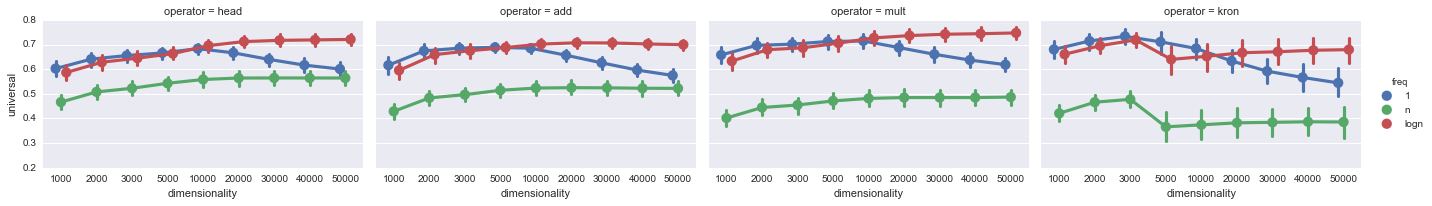

In [210]:
t.plot_interaction(_results.loc[['add', 'head', 'mult', 'kron'], 'max'], feature_ablation_universal.index[0], 'universal')

In [211]:
assert feature_ablation_universal.index[0] == 'freq'

r = _results.loc[['add', 'head', 'mult', 'kron'], 'max'].reset_index()

heuristics_selection_collection_universal[0] =  r.loc[
    (~(((r['operator'] == 'head') & (r['dimensionality'] < 10000))) | ((r['freq'] == '1'))) &
    (~(((r['operator'] == 'head') & (r['dimensionality'] >= 10000))) | ((r['freq'] == 'logn'))) &

    (~(((r['operator'] == 'add') & (r['dimensionality'] < 10000))) | ((r['freq'] == '1'))) &
    (~(((r['operator'] == 'add') & (r['dimensionality'] >= 10000))) | ((r['freq'] == 'logn'))) &

    (~(((r['operator'] == 'mult') & (r['dimensionality'] < 10000))) | ((r['freq'] == '1'))) &
    (~(((r['operator'] == 'mult') & (r['dimensionality'] >= 10000))) | ((r['freq'] == 'logn'))) &

    (~(((r['operator'] == 'kron') & (r['dimensionality'] < 20000))) | ((r['freq'] == '1'))) &
    (~(((r['operator'] == 'kron') & (r['dimensionality'] >= 20000))) | ((r['freq'] == 'logn'))) &

    True
]

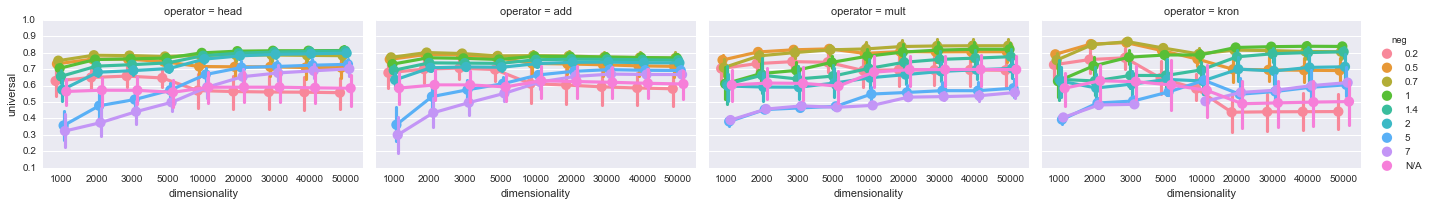

In [212]:
t.plot_interaction(heuristics_selection_collection_universal[0], feature_ablation_universal.index[1], 'universal')

In [213]:
assert feature_ablation_universal.index[1] == 'neg'

r = heuristics_selection_collection_universal[0]

heuristics_selection_collection_universal[1] =  r.loc[
    (~(((r['operator'] == 'head') & (r['dimensionality'] < 10000))) | ((r['neg'] == 0.7))) &
    (~(((r['operator'] == 'head') & (r['dimensionality'] >= 10000))) | ((r['neg'] == 1))) &

    (~(((r['operator'] == 'add'))) | ((r['neg'] == 0.7))) &

    (~(((r['operator'] == 'mult') & (r['dimensionality'] < 10000))) | ((r['neg'] == 0.5))) &
    (~(((r['operator'] == 'mult') & (r['dimensionality'] >= 10000))) | ((r['neg'] == 0.7))) &

    (~(((r['operator'] == 'kron') & (r['dimensionality'] < 20000))) | ((r['neg'] == 0.7))) &
    (~(((r['operator'] == 'kron') & (r['dimensionality'] >= 20000))) | ((r['neg'] == 1))) &

    True
]

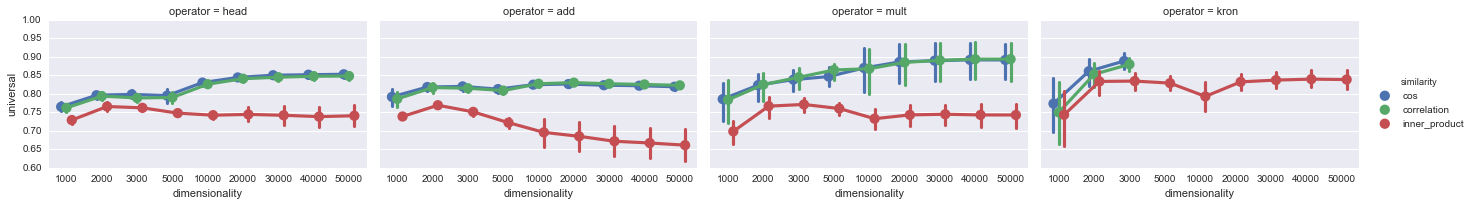

In [214]:
t.plot_interaction(heuristics_selection_collection_universal[1], feature_ablation_universal.index[2], 'universal')

In [215]:
assert feature_ablation_universal.index[2] == 'similarity'

r = heuristics_selection_collection_universal[1]

heuristics_selection_collection_universal[2] =  r.loc[
    (~((r['operator'] == 'head')) | ((r['similarity'] == 'cos'))) &
    (~((r['operator'] == 'add')) | ((r['similarity'] == 'correlation'))) &
    (~((r['operator'] == 'mult')) | ((r['similarity'] == 'correlation'))) &

    (~(((r['operator'] == 'kron') & (r['dimensionality'] < 5000))) | ((r['similarity'] == 'cos'))) &
    (~(((r['operator'] == 'kron') & (r['dimensionality'] >= 5000))) | ((r['similarity'] == 'inner_product'))) &

    True
]

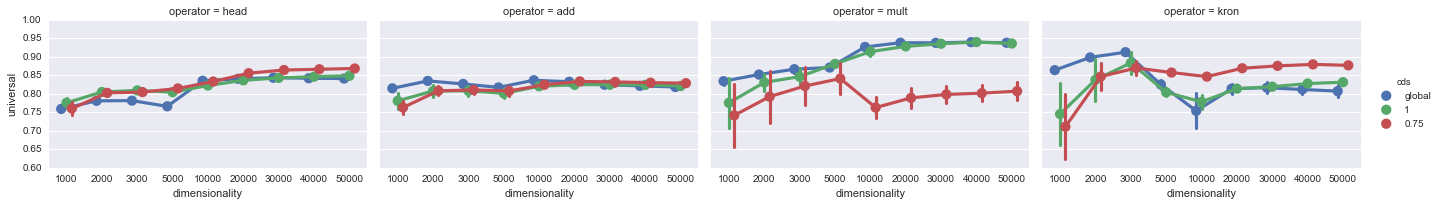

In [216]:
t.plot_interaction(heuristics_selection_collection_universal[2], feature_ablation_universal.index[3], 'universal')

In [217]:
assert feature_ablation_universal.index[3] == 'cds'

r = heuristics_selection_collection_universal[2]

heuristics_selection_collection_universal[3] =  r.loc[
    (~((r['operator'] == 'head')) | ((r['cds'] == '0.75'))) &

    (~(((r['operator'] == 'add') & (r['dimensionality'] < 20000))) | ((r['cds'] == 'global'))) &
    (~(((r['operator'] == 'add') & (r['dimensionality'] >= 20000))) | ((r['cds'] == '0.75'))) &
    
    (~((r['operator'] == 'mult')) | ((r['cds'] == 'global'))) &

    (~(((r['operator'] == 'kron') & (r['dimensionality'] < 5000))) | ((r['cds'] == 'global'))) &
    (~(((r['operator'] == 'kron') & (r['dimensionality'] >= 5000))) | ((r['cds'] == '0.75'))) &

    True
]

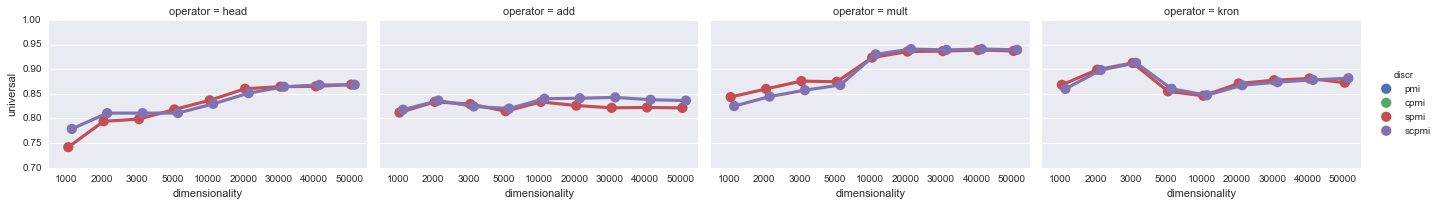

In [218]:
t.plot_interaction(heuristics_selection_collection_universal[3], feature_ablation_universal.index[4], 'universal')

In [219]:
assert feature_ablation_universal.index[4] == 'discr'

r = heuristics_selection_collection_universal[3]

heuristics_selection_collection_universal[4] =  r.loc[
    (~((r['operator'] == 'head') & (r['dimensionality'] < 5000)) | ((r['discr'] == 'scpmi'))) &
    (~((r['operator'] == 'head') & (r['dimensionality'] >= 5000)) | ((r['discr'] == 'spmi'))) &

    (~((r['operator'] == 'add')) | ((r['discr'] == 'scpmi'))) &

    (~((r['operator'] == 'mult') & (r['dimensionality'] < 10000)) | ((r['discr'] == 'spmi'))) &
    (~((r['operator'] == 'mult') & (r['dimensionality'] >= 10000)) | ((r['discr'] == 'scpmi'))) &

    (~((r['operator'] == 'kron')) | ((r['discr'] == 'spmi'))) &

    True
]

In [220]:
assert feature_ablation_universal.index[5] == 'dimensionality'

In [221]:
assert feature_ablation_universal.index[6] == 'operator'

In [222]:
assert len(feature_ablation_universal) == 7

In [223]:
heuristics_selection_universal = heuristics_selection_collection_universal[4].set_index(['operator', 'dimensionality'], drop=False)
heuristics_selection_universal['selection'] = 'heuristics'
heuristics_selection_universal.sort_index(inplace=True)

In [224]:
pd.concat(
    [
            heuristics_selection_universal.loc[
                ['head', '']
            ],        
            heuristics_selection_universal.loc[
                ['add', 'mult']
            ],
            heuristics_selection_universal.loc[
                ['kron', '']
            ],        
        ]
).round(
    {
        'SimLex999': 3, 'men': 3,
        'KS14': 3, 'GS11': 3, 'PhraseRel': 3,
        'universal': 3,
    }
).to_latex(
    'figures/universal-heuristics-selection.tex',
    columns=[
        'SimLex999',
        'men',
        'KS14',
        'GS11',
        'PhraseRel',
        'universal',
        'freq',
        'discr',
        'cds',
        'neg',
        'similarity',
    ],
)

In [225]:
_lexical_selections = pd.concat(
    [
        pd.concat(
            [
                _results.loc[operator].loc[max_selection_lexical.set_index([n for n in _results.index.names if n != 'operator']).index]
                ['max'].assign(operator=operator).reset_index().set_index(['operator', 'dimensionality'], drop=False)
                for operator in ('head', 'add', 'mult', 'kron')
            ]
        ).assign(selection='lexical, max_'),

        pd.concat(
            [
                _results.loc[operator].loc[heuristics_selection_lexical.set_index([n for n in _results.index.names if n != 'operator']).index]
                ['max'].assign(operator=operator).reset_index().set_index(['operator', 'dimensionality'], drop=False)
                for operator in ('head', 'add', 'mult', 'kron')
            ]
        ).assign(selection='lexical, heuristics'),

    ]
)

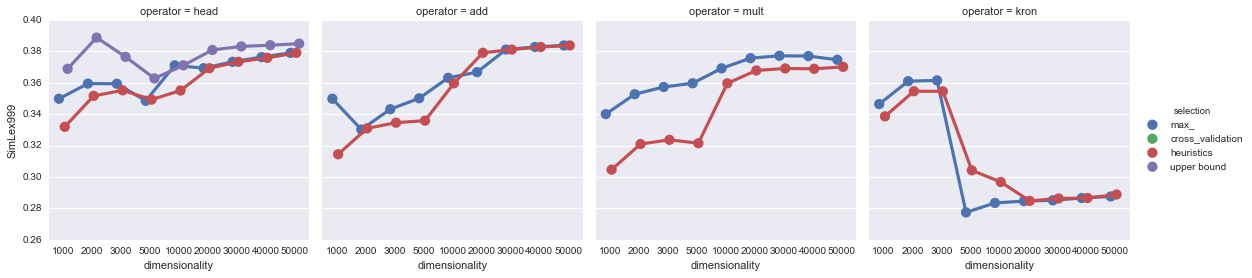

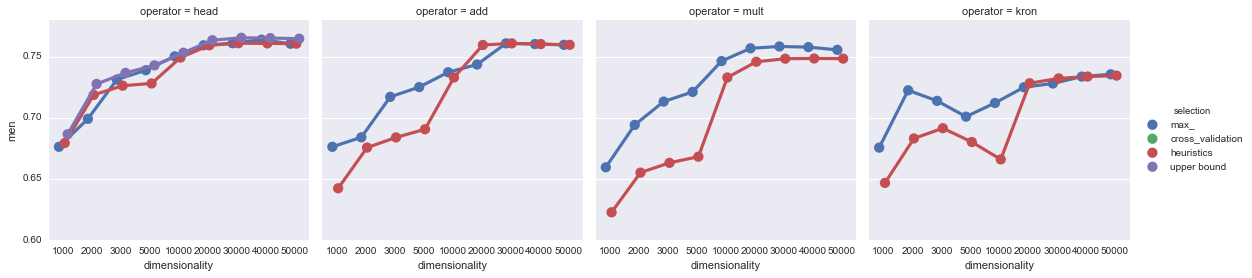

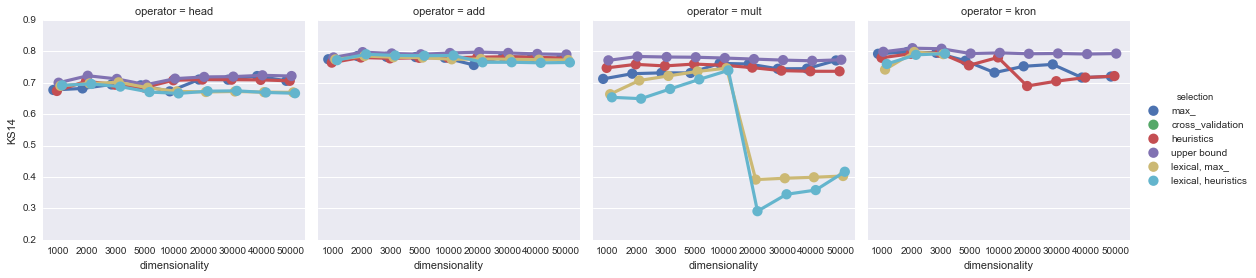

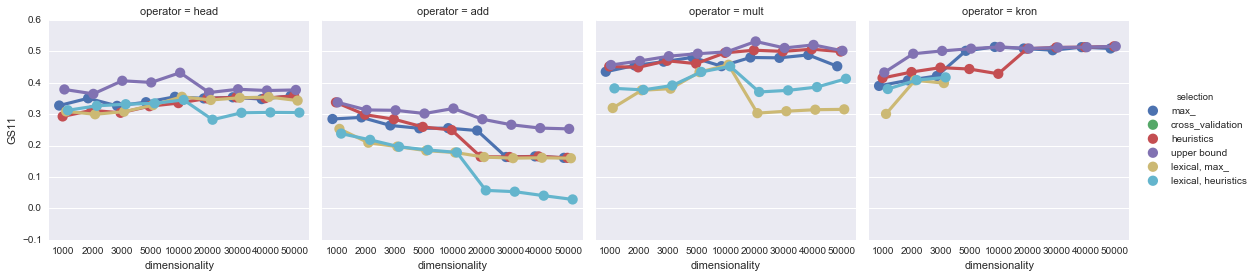

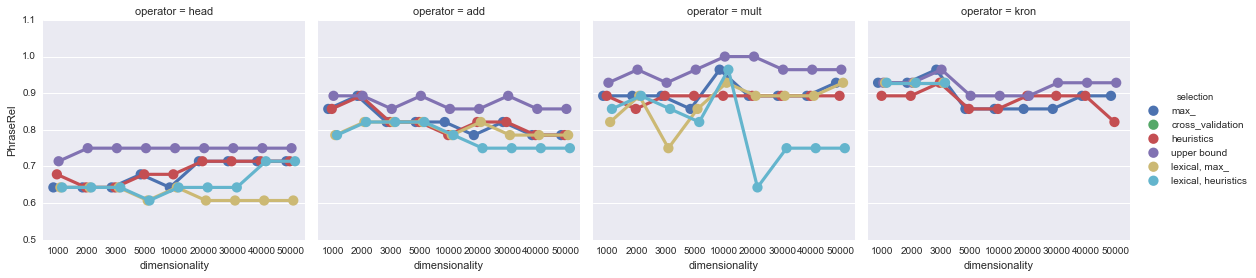

In [226]:
t.plot_parameter_selection_comparison(
    [
        max_selection_universal,
        heuristics_selection_universal,

        max_selection_simlex.assign(selection='upper bound'),
    ],
    'SimLex999',
    'SimLex999',
    col='operator',

).fig.savefig('figures/universal-results-simlex999.pdf')

t.plot_parameter_selection_comparison(
    [
        max_selection_universal,
        heuristics_selection_universal,
        
        max_selection_men.assign(selection='upper bound'),
],
    'men',
    'men',
    col='operator',

).fig.savefig('figures/universal-results-men.pdf')

t.plot_parameter_selection_comparison(
    [
        max_selection_universal,
        heuristics_selection_universal,
        
        max_selection_ks14.assign(selection='upper bound'),
        
        _lexical_selections,
    ],
    'KS14',
    'KS14',
    col='operator',
    extra_hue=('lexical, max_', 'lexical, heuristics'),
).fig.savefig('figures/universal-results-ks14.pdf')

t.plot_parameter_selection_comparison(
    [
        max_selection_universal,
        heuristics_selection_universal,
        
        max_selection_gs11.assign(selection='upper bound'),

        _lexical_selections,
    ],
    'GS11',
    'GS11',
    col='operator',
    extra_hue=('lexical, max_', 'lexical, heuristics'),
).fig.savefig('figures/universal-results-gs11.pdf')

t.plot_parameter_selection_comparison(
    [
        max_selection_universal,
        heuristics_selection_universal,
        
        max_selection_phraserel.assign(selection='upper bound'),

        _lexical_selections,
    ],
    'PhraseRel',
    'PhraseRel',
    col='operator',
    extra_hue=('lexical, max_', 'lexical, heuristics'),
).fig.savefig('figures/universal-results-PhraseRel.pdf')

## One for all space

In [227]:
_ = _results.loc[['head', 'add', 'mult', 'kron']].unstack('operator')['max'][['SimLex999', 'men', 'GS11', 'KS14', 'PhraseRel']]

_single_score = pd.DataFrame(
    {
        'single': (
            _['SimLex999', 'head'] / _['SimLex999', 'head'].max()  / 4 +
            _['men', 'head'] / _['men', 'head'].max() / 4 +

            _['GS11', 'add'] / _['GS11', 'add'].max() / 12 +
            _['GS11', 'mult'] / _['GS11', 'mult'].max() / 12 +
#             _['GS11', 'kron'] / _['GS11', 'kron'].max() / 18 +

            _['KS14', 'add'] / _['KS14', 'add'].max() / 12 +
            _['KS14', 'mult'] / _['KS14', 'mult'].max() / 12 +
#             _['KS14', 'kron'] / _['KS14', 'kron'].max() / 18 +

            _['PhraseRel', 'add'] / _['PhraseRel', 'add'].max() / 12 +
            _['PhraseRel', 'mult'] / _['PhraseRel', 'mult'].max() / 12 +
#             _['PhraseRel', 'kron'] / _['PhraseRel', 'kron'].max() / 18 +
            0
        ),
    }
)

_results['max', 'single'] = pd.concat(
    [
        _single_score.assign(operator='head'),
        _single_score.assign(operator='add'),
        _single_score.assign(operator='mult'),
        _single_score.assign(operator='kron'),
    ]
).reset_index().set_index(_results.index.names)['single']


In [229]:
max_selection_single = t.plot_selection(
    _results.loc[['add', 'head', 'mult', 'kron']],
    dataset='single',
    selector_function=t.max_('SimLex999', 'men', 'KS14', 'GS11', 'PhraseRel', 'universal'),
    plot=False,
)

In [230]:
_ = pd.concat(
    [
            max_selection_single.loc[
                ['head', '']
            ],        
            max_selection_single.loc[
                ['add', 'mult']
            ],
            max_selection_single.loc[
                ['kron', '']
            ],        
        ]
).round(
    {
        'SimLex999': 3, 'men': 3,
        'KS14': 3, 'GS11': 3, 'PhraseRel': 3,
        'universal': 3,
    }
)

_ = _.set_index(compositional_parameters + ['reduction', 'base', 'context_type', 'corpus'])
_ = _.unstack('operator').swaplevel(0, 1, axis='columns')[
    [
        ('head', 'SimLex999'),
        ('head', 'men'),
        #('head', 'universal'),
        #('head', 'single'),

        #('head', 'KS14'),
        #('head', 'GS11'),
        #('head', 'PhraseRel'),

        ('add', 'KS14'),
        ('add', 'GS11'),
        ('add', 'PhraseRel'),
        #('add', 'universal'),

        ('mult', 'KS14'),
        ('mult', 'GS11'),
        ('mult', 'PhraseRel'),

        ('kron', 'KS14'),
        ('kron', 'GS11'),
        ('kron', 'PhraseRel'),
    ]
].reset_index(['reduction', 'base', 'context_type', 'corpus'], drop=True)

_.to_latex(
    'figures/single-max_-selection.tex',
)

_

operator                                              head           add  \
                                                 SimLex999    men   KS14   
dimensionality discr cds    freq neg similarity                            
1000           scpmi global 1    0.7 cos             0.335  0.647  0.740   
2000           scpmi global 1    0.7 cos             0.352  0.684  0.754   
3000           scpmi global 1    0.7 cos             0.348  0.692  0.757   
5000           cpmi  1      logn N/A correlation     0.350  0.725  0.782   
10000          scpmi global logn 0.7 correlation     0.360  0.733  0.779   
20000          cpmi  1      logn N/A correlation     0.372  0.749  0.775   
30000          scpmi 1      logn 0.7 correlation     0.373  0.758  0.785   
40000          scpmi 1      logn 0.7 correlation     0.373  0.757  0.779   
50000          scpmi global logn 0.7 correlation     0.370  0.748  0.762   

operator                                                            mult  \
                                                   GS11 PhraseRel   KS14   
dimensionality discr cds    freq neg similarity                            
1000           scpmi global 1    0.7 cos          0.321     0.857  0.726   
2000           scpmi global 1    0.7 cos          0.293     0.786  0.743   
3000           scpmi global 1    0.7 cos          0.291     0.821  0.742   
5000           cpmi  1      logn N/A correlation  0.255     0.821  0.753   
10000          scpmi global logn 0.7 correlation  0.249     0.786  0.756   
20000          cpmi  1      logn N/A correlation  0.243     0.714  0.738   
30000          scpmi 1      logn 0.7 correlation  0.174     0.786  0.747   
40000          scpmi 1      logn 0.7 correlation  0.171     0.786  0.749   
50000          scpmi global logn 0.7 correlation  0.201     0.714  0.737   

operator                                                            kron  \
                                                   GS11 PhraseRel   KS14   
dimensionality discr cds    freq neg similarity                            
1000           scpmi global 1    0.7 cos          0.443     0.893  0.763   
2000           scpmi global 1    0.7 cos          0.446     0.821  0.784   
3000           scpmi global 1    0.7 cos          0.485     0.857  0.784   
5000           cpmi  1      logn N/A correlation  0.427     0.893    NaN   
10000          scpmi global logn 0.7 correlation  0.495     0.893    NaN   
20000          cpmi  1      logn N/A correlation  0.440     1.000    NaN   
30000          scpmi 1      logn 0.7 correlation  0.481     0.893    NaN   
40000          scpmi 1      logn 0.7 correlation  0.492     0.893    NaN   
50000          scpmi global logn 0.7 correlation  0.499     0.893    NaN   

operator                                                           
                                                   GS11 PhraseRel  
dimensionality discr cds    freq neg similarity                    
1000           scpmi global 1    0.7 cos          0.427     0.857  
2000           scpmi global 1    0.7 cos          0.443     0.893  
3000           scpmi global 1    0.7 cos          0.467     0.929  
5000           cpmi  1      logn N/A correlation    NaN       NaN  
10000          scpmi global logn 0.7 correlation    NaN       NaN  
20000          cpmi  1      logn N/A correlation    NaN       NaN  
30000          scpmi 1      logn 0.7 correlation    NaN       NaN  
40000          scpmi 1      logn 0.7 correlation    NaN       NaN  
50000          scpmi global logn 0.7 correlation    NaN       NaN

In [233]:
'{:.3f}'.format(
    t.anova(
        response='single',
        predictors=parameters,
        data=_results.loc[['add', 'head', 'mult']],
    ).rsquared_adj
)

'0.899'

In [234]:
feature_ablation_single = t.calculate_feature_ablation(
    responses=(
        'single',
    ),
    predictors=parameters,
    data=_results.loc[['head', 'add', 'mult']],
)

feature_ablation_single.sort_values(('partial R2', 'single'), ascending=False, inplace=True)

feature_ablation_single.round(3)

,partial R2
response,single
predictor,
freq,0.434
similarity,0.269
neg,0.196
discr,0.092
cds,0.090
dimensionality,0.034


In [235]:
_ = feature_ablation_single.copy()
_.columns.names = ['', '']
(
    _['partial R2']
    .round(3)
    .to_latex('figures/single-ablation.tex')
)

In [236]:
heuristics_selection_collection_single = {}

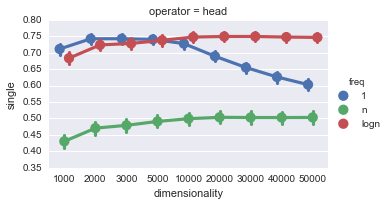

In [237]:
t.plot_interaction(_results.loc[['add', 'head', 'mult'], 'max'], feature_ablation_single.index[0], 'single')

In [242]:
assert feature_ablation_single.index[0] == 'freq'

r = _results.loc[['add', 'head', 'mult', 'kron'], 'max'].reset_index()

heuristics_selection_collection_single[0] =  r.loc[
    (~(((r['dimensionality'] < 20000))) | ((r['freq'] == '1'))) &
    (~(((r['dimensionality'] >= 20000))) | ((r['freq'] == 'logn'))) &

    True
]

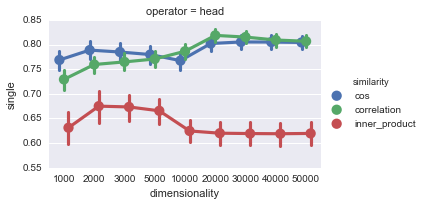

In [243]:
t.plot_interaction(heuristics_selection_collection_single[0], feature_ablation_single.index[1], 'single')

In [244]:
assert feature_ablation_single.index[1] == 'similarity'

r = heuristics_selection_collection_single[0]

heuristics_selection_collection_single[1] =  r.loc[
    (~(((r['dimensionality'] < 20000))) | ((r['similarity'] == 'cos'))) &
    (~(((r['dimensionality'] >= 20000))) | ((r['similarity'] == 'correlation'))) &

    True
]

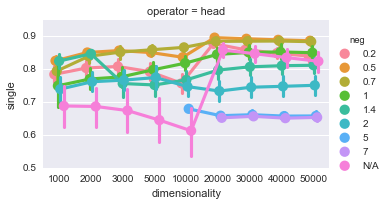

In [245]:
t.plot_interaction(heuristics_selection_collection_single[1], feature_ablation_single.index[2], 'single')

In [246]:
assert feature_ablation_single.index[2] == 'neg'

r = heuristics_selection_collection_single[1]

heuristics_selection_collection_single[2] =  r.loc[
    (r['neg'] == 0.7)
]

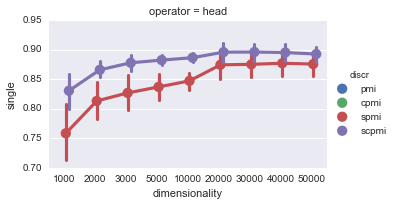

In [247]:
t.plot_interaction(heuristics_selection_collection_single[2], feature_ablation_single.index[3], 'single')

In [248]:
assert feature_ablation_single.index[3] == 'discr'

r = heuristics_selection_collection_single[2]

heuristics_selection_collection_single[3] =  r.loc[
    (r['discr'] == 'scpmi')
]

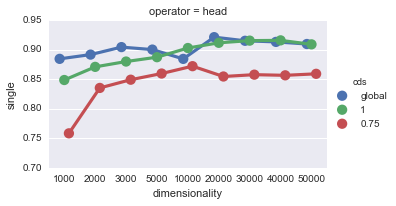

In [249]:
t.plot_interaction(heuristics_selection_collection_single[3], feature_ablation_single.index[4], 'single')

In [250]:
assert feature_ablation_single.index[4] == 'cds'

r = heuristics_selection_collection_single[3]

heuristics_selection_collection_single[4] =  r.loc[
    (r['cds'] == 'global')
]

In [251]:
assert feature_ablation_single.index[5] == 'dimensionality'

In [252]:
assert len(feature_ablation_single.index) == 6

In [253]:
heuristics_selection_single = heuristics_selection_collection_single[4].set_index(['operator', 'dimensionality'], drop=False)
heuristics_selection_single['selection'] = 'heuristics'
heuristics_selection_single.sort_index(inplace=True)

In [254]:
_ = pd.concat(
    [
            heuristics_selection_single.loc[
                ['head', '']
            ],        
            heuristics_selection_single.loc[
                ['add', 'mult']
            ],
            heuristics_selection_single.loc[
                ['kron', '']
            ],        
        ]
).round(
    {
        'SimLex999': 3, 'men': 3,
        'KS14': 3, 'GS11': 3, 'PhraseRel': 3,
        'universal': 3, 'single': 3,
    }
)

_ = _.set_index(compositional_parameters + ['reduction', 'base', 'context_type', 'corpus'])
_ = _.unstack('operator').swaplevel(0, 1, axis='columns')[
    [
        ('head', 'SimLex999'),
        ('head', 'men'),
        #('head', 'universal'),
        #('head', 'single'),

        #('head', 'KS14'),
        #('head', 'GS11'),
        #('head', 'PhraseRel'),

        ('add', 'KS14'),
        ('add', 'GS11'),
        ('add', 'PhraseRel'),
        #('add', 'universal'),

        ('mult', 'KS14'),
        ('mult', 'GS11'),
        ('mult', 'PhraseRel'),

        ('kron', 'KS14'),
        ('kron', 'GS11'),
        ('kron', 'PhraseRel'),
    ]
].reset_index(['reduction', 'base', 'context_type', 'corpus'], drop=True)

_.to_latex(
    'figures/single-heuristics-selection.tex',
)

_

operator                                              head           add  \
                                                 SimLex999    men   KS14   
dimensionality discr cds    freq neg similarity                            
1000           scpmi global 1    0.7 cos             0.335  0.647  0.740   
2000           scpmi global 1    0.7 cos             0.352  0.684  0.754   
3000           scpmi global 1    0.7 cos             0.348  0.692  0.757   
5000           scpmi global 1    0.7 cos             0.345  0.696  0.752   
10000          scpmi global 1    0.7 cos             0.335  0.696  0.742   
20000          scpmi global logn 0.7 correlation     0.368  0.746  0.771   
30000          scpmi global logn 0.7 correlation     0.369  0.748  0.770   
40000          scpmi global logn 0.7 correlation     0.369  0.748  0.767   
50000          scpmi global logn 0.7 correlation     0.370  0.748  0.762   

operator                                                            mult  \
                                                   GS11 PhraseRel   KS14   
dimensionality discr cds    freq neg similarity                            
1000           scpmi global 1    0.7 cos          0.321     0.857  0.726   
2000           scpmi global 1    0.7 cos          0.293     0.786  0.743   
3000           scpmi global 1    0.7 cos          0.291     0.821  0.742   
5000           scpmi global 1    0.7 cos          0.265     0.821  0.740   
10000          scpmi global 1    0.7 cos          0.243     0.750  0.753   
20000          scpmi global logn 0.7 correlation  0.232     0.750  0.748   
30000          scpmi global logn 0.7 correlation  0.221     0.714  0.739   
40000          scpmi global logn 0.7 correlation  0.212     0.714  0.737   
50000          scpmi global logn 0.7 correlation  0.201     0.714  0.737   

operator                                                            kron  \
                                                   GS11 PhraseRel   KS14   
dimensionality discr cds    freq neg similarity                            
1000           scpmi global 1    0.7 cos          0.443     0.893  0.763   
2000           scpmi global 1    0.7 cos          0.446     0.821  0.784   
3000           scpmi global 1    0.7 cos          0.485     0.857  0.784   
5000           scpmi global 1    0.7 cos          0.493     0.893    NaN   
10000          scpmi global 1    0.7 cos          0.488     0.929    NaN   
20000          scpmi global logn 0.7 correlation  0.504     0.893    NaN   
30000          scpmi global logn 0.7 correlation  0.500     0.893    NaN   
40000          scpmi global logn 0.7 correlation  0.507     0.893    NaN   
50000          scpmi global logn 0.7 correlation  0.499     0.893    NaN   

operator                                                           
                                                   GS11 PhraseRel  
dimensionality discr cds    freq neg similarity                    
1000           scpmi global 1    0.7 cos          0.427     0.857  
2000           scpmi global 1    0.7 cos          0.443     0.893  
3000           scpmi global 1    0.7 cos          0.467     0.929  
5000           scpmi global 1    0.7 cos            NaN       NaN  
10000          scpmi global 1    0.7 cos            NaN       NaN  
20000          scpmi global logn 0.7 correlation    NaN       NaN  
30000          scpmi global logn 0.7 correlation    NaN       NaN  
40000          scpmi global logn 0.7 correlation    NaN       NaN  
50000          scpmi global logn 0.7 correlation    NaN       NaN

# Frobenious operators

In [255]:
selection_to_test = pd.concat(
    [
        max_selection_universal[max_selection_universal['dimensionality'] < 5000][parameters].assign(
            selection='universal_max'
        ).set_index('selection', append=True).reorder_levels(['selection', 'operator', 'dimensionality']),

        heuristics_selection_universal.loc[['head', 'add', 'mult', 'kron']][
            heuristics_selection_universal.loc[['head', 'add', 'mult', 'kron']]['dimensionality'] < 5000
        ][parameters].assign(
            selection='universal_heuristics'
        ).set_index('selection', append=True).reorder_levels(['selection', 'operator', 'dimensionality']),

        max_selection_single[max_selection_single['dimensionality'] < 5000][parameters].assign(
            selection='single'
        ).set_index('selection', append=True, drop=False).loc[['head']].reorder_levels(['selection', 'operator', 'dimensionality']),

#         heuristics_selection_single.loc[['head']][
#             heuristics_selection_single.loc[['head']]['dimensionality'] < 5000
#         ][parameters].assign(
#             selection='single_heuristics'
#         ).set_index('selection', append=True).reorder_levels(['selection', 'operator', 'dimensionality']),
    ]
)

In [256]:
frobenious_results = selection_to_test.merge(
    _results.loc[
        [
            'relational',
            'copy-object',
            'copy-subject',
            'frobenious-add',
            'frobenious-mult',
            'frobenious-outer',
        ],
        'max',
    ]
    .reset_index('operator')
    .reset_index(['corpus', 'reduction', 'base', 'context_type'], drop=True)
    .reorder_levels(parameters),
    left_on=parameters,
    right_index=True,
    how='left',
).sortlevel()

In [257]:
frobenious_results['selection'] = frobenious_results.index.get_level_values('selection')
frobenious_results['selection_operator'] = frobenious_results.index.get_level_values('operator')

frobenious_results['selection_name'] = frobenious_results['selection'] + '_' + frobenious_results['selection_operator']

In [296]:
_ = frobenious_results[
    frobenious_results['SimLex999'].isnull() |
    frobenious_results['men'].isnull() |
    frobenious_results['KS14'].isnull() |
    frobenious_results['GS11'].isnull() |
    frobenious_results['PhraseRel'].isnull() |
    True
].drop(
    [
        'selection',
#         'operator',
        'lexical', 'compositional', 'universal', 'single',
        'selection_operator', 'selection_name',
    ],
    axis='columns'
).reset_index(drop=True).set_index(
    ['dimensionality', 'freq', 'discr', 'neg', 'cds', 'operator']
).drop('similarity', axis='columns').sortlevel()

_ = _[~_.index.duplicated()]

_ = _.unstack('operator')

_[['KS14', 'GS11', 'PhraseRel']].round(3).fillna('')

KS14                              \
operator                             copy-object copy-subject frobenious-add   
dimensionality freq discr neg cds                                              
1000           1    scpmi 0.7 0.75         0.522        0.633          0.657   
                              global       0.601        0.701          0.712   
                          1.0 global         0.6        0.738          0.745   
                    spmi  0.5 global       0.592        0.713          0.724   
                          0.7 global         0.6        0.714          0.724   
               logn spmi  0.7 global       0.601        0.709          0.722   
                          1.0 global       0.604        0.732          0.741   
2000           1    cpmi  N/A 1             0.61         0.73           0.75   
                    scpmi 0.7 0.75                                             
                              global                                           
                    spmi  0.5 global                                           
                          0.7 global                                           
                          1.0 global                                           
               logn scpmi 1.0 global                                           
                    spmi  0.2 1                                                
3000           1    scpmi 0.7 0.75                                             
                              global                                           
                          1.0 global                                           
                    spmi  0.5 global                                           
                          0.7 global                                           
               logn cpmi  N/A 1             0.62        0.731          0.751   
                    scpmi 1.0 global                                           
                    spmi  0.7 global                                           

                                                                       \
operator                             frobenious-mult frobenious-outer   
dimensionality freq discr neg cds                                       
1000           1    scpmi 0.7 0.75             0.135            0.678   
                              global           0.694            0.729   
                          1.0 global           0.668            0.743   
                    spmi  0.5 global           0.721             0.73   
                          0.7 global           0.693            0.734   
               logn spmi  0.7 global           0.682            0.732   
                          1.0 global           0.659            0.737   
2000           1    cpmi  N/A 1                0.747            0.763   
                    scpmi 0.7 0.75                                      
                              global                                    
                    spmi  0.5 global                                    
                          0.7 global                                    
                          1.0 global                                    
               logn scpmi 1.0 global                                    
                    spmi  0.2 1                                         
3000           1    scpmi 0.7 0.75                                      
                              global                                    
                          1.0 global                                    
                    spmi  0.5 global                                    
                          0.7 global                                    
               logn cpmi  N/A 1                0.708            0.762   
                    scpmi 1.0 global                                    
                    spmi  0.7 global                                    

                                                       GS11     

In [297]:
import seaborn as sns

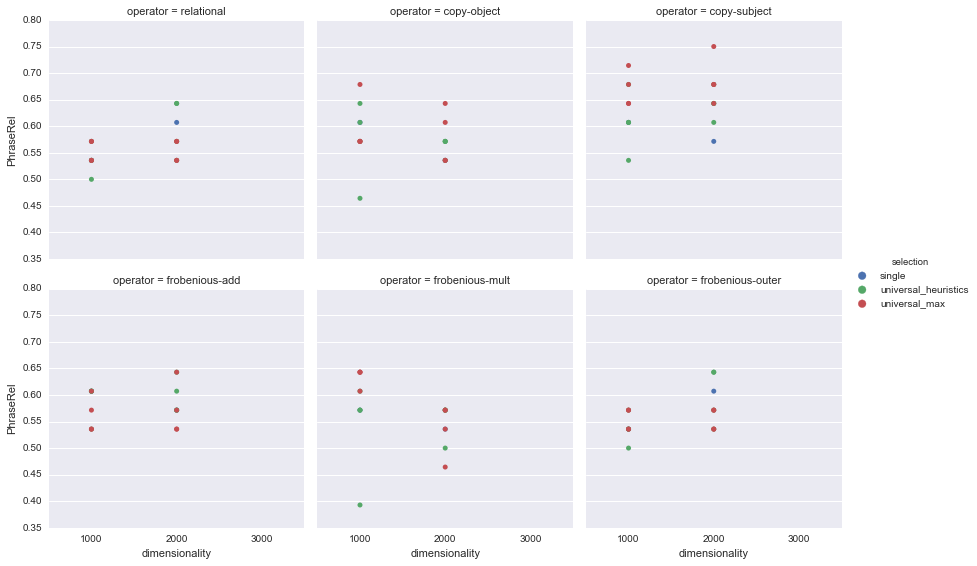

In [308]:
sns.factorplot(
    data=frobenious_results,
    y='PhraseRel',
    x='dimensionality',
    hue='selection',
    col='operator',
    col_order=[
        'relational',
        'copy-object',
        'copy-subject',
        'frobenious-add',
        'frobenious-mult',
        'frobenious-outer',
    ],
    col_wrap=3,
#     dodge=0.3,
    kind='strip',
)